In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# output_dir = Path('/home/tornikeo/Documents/personal/thesis/text-silo/resources')
output_dir = Path('/home/tornikeo/Documents/personal/thesis/text-silo/thesis/resources')
!mkdir -p {output_dir}

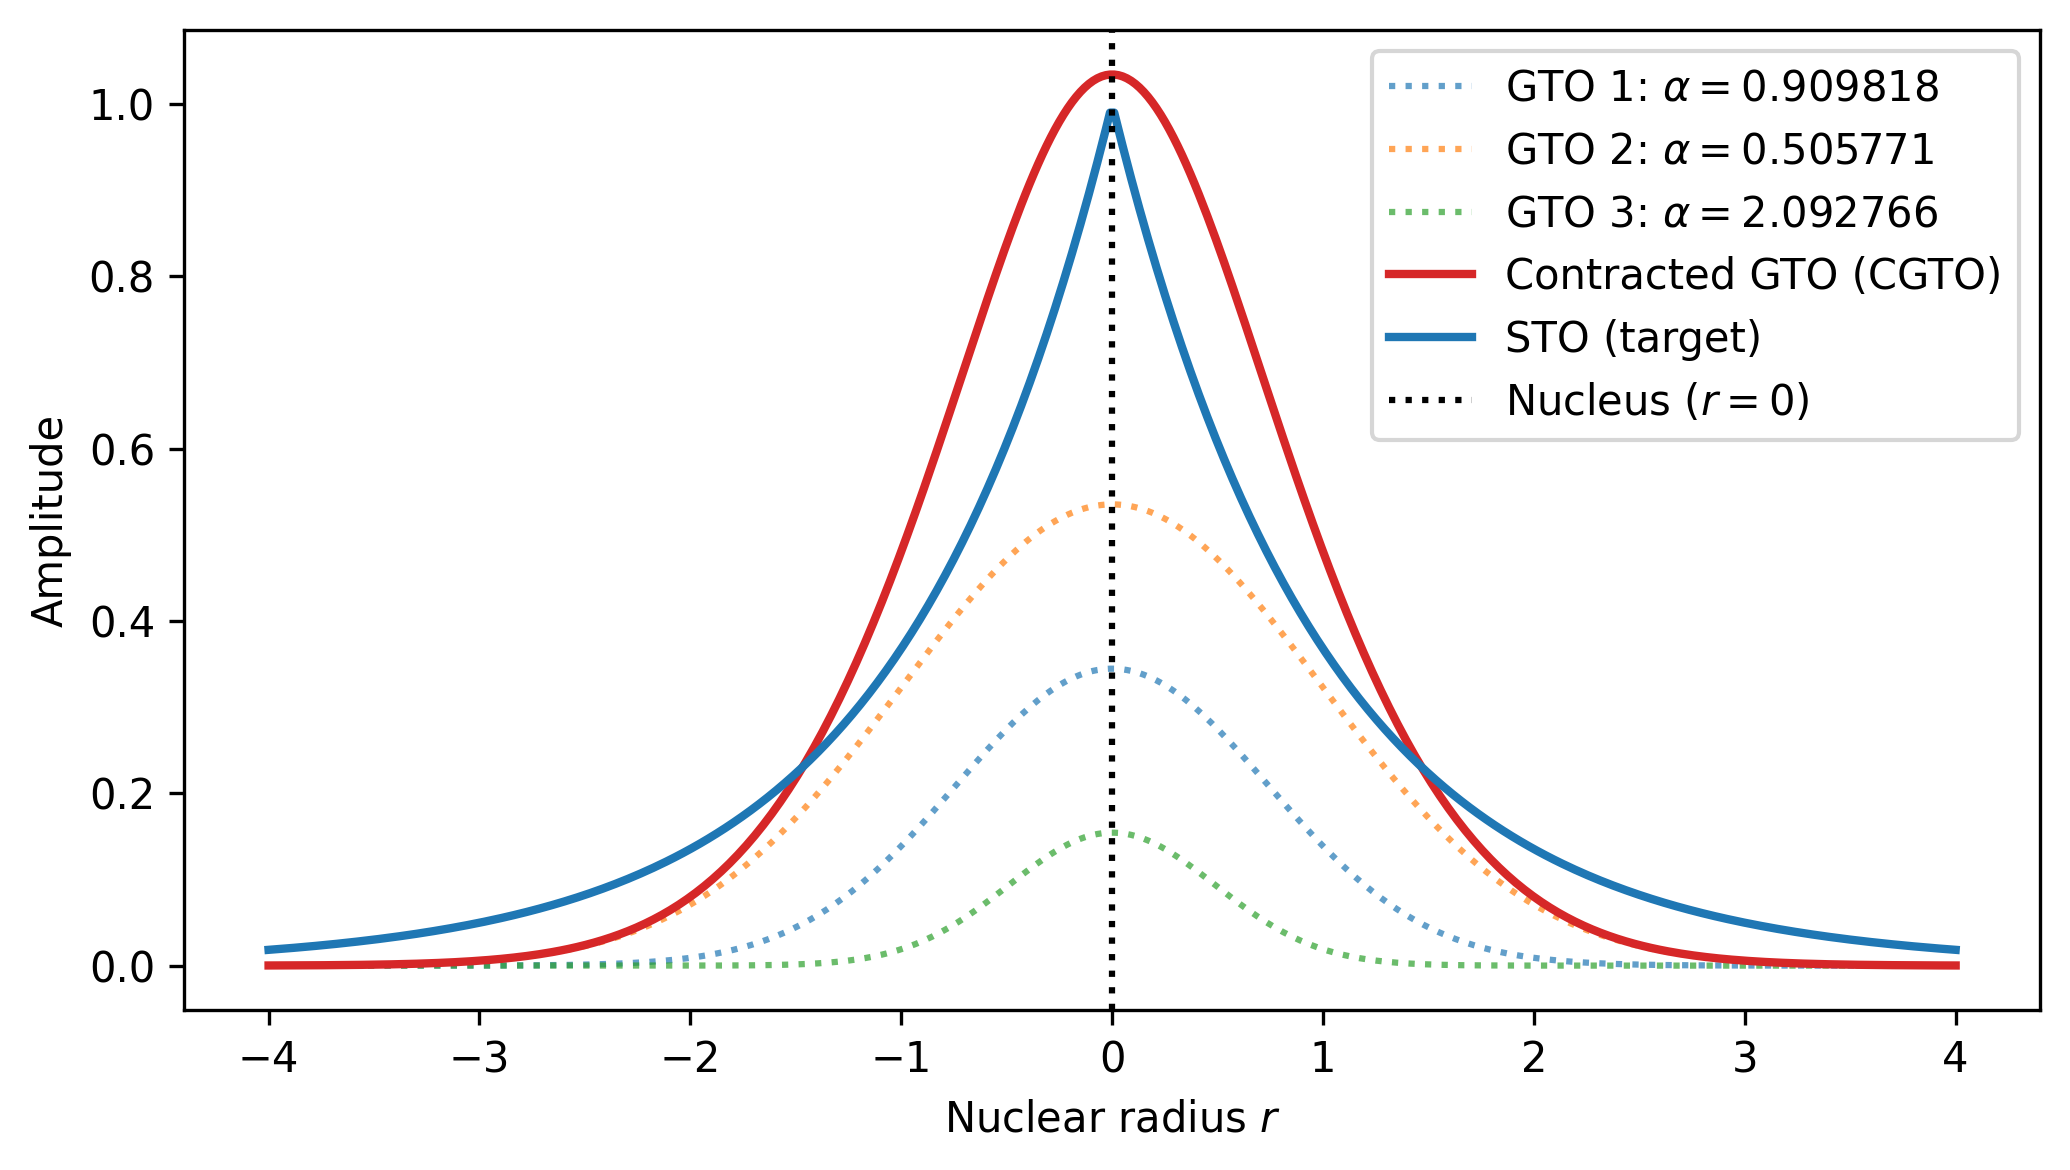

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
r = np.linspace(-4, 4, 400)  # Symmetric range
zeta = 1.0  # STO exponent

# STO
sto = np.exp(-zeta * np.abs(r))

# STO-3G contraction coefficients and exponents for 1s orbital (H atom)
alphas = [0.909818, 0.505771, 2.092766]
coeffs = [0.344635, 0.535328, 0.154329]
gto_curves = [c * np.exp(-a * r**2) for c, a in zip(coeffs, alphas)]
cgto = np.sum(gto_curves, axis=0)

# Plot all on one wide figure
plt.figure(figsize=(7, 4), dpi=300)
for i, (gto, a) in enumerate(zip(gto_curves, alphas)):
    plt.plot(r, gto, ':', label=f'GTO {i+1}: $\\alpha={a}$', alpha=0.7)
plt.plot(r, cgto, label='Contracted GTO (CGTO)', color='C3', linewidth=2)
plt.plot(r, sto, '-', label='STO (target)', color='C0', linewidth=2)
plt.axvline(0, color='k', linestyle=':', label='Nucleus ($r=0$)')
plt.xlabel('Nuclear radius $r$')
plt.ylabel('Amplitude')
# plt.title('STO and its Gaussian Approximation (STO-3G, centered at nucleus $x=0$)')
plt.legend()
plt.tight_layout()
plt.savefig(output_dir / 'cgto_fit.png')
plt.show()

In [11]:
from datasets import load_dataset

ds = load_dataset('roman-bushuiev/MassSpecGym', data_dir='data', data_files='MassSpecGym.tsv')
df = ds['train'].to_pandas()

identifier                                           MassSpecGymID0026634
mzs                     42.0448,53.0195,53.0255,56.055,67.0339,68.0418...
intensities             0.7687687687687688,0.03403403403403404,0.04204...
smiles                                       CN1C=NC2=C1C(=O)N(C(=O)N2C)C
inchikey                                                   RYYVLZVUVIJVGH
formula                                                         C8H10N4O2
precursor_formula                                               C8H11N4O2
parent_mass                                                    194.080424
precursor_mz                                                     195.0877
adduct                                                             [M+H]+
instrument_type                                                      QTOF
collision_energy                                                     50.0
fold                                                                train
simulation_challenge                  

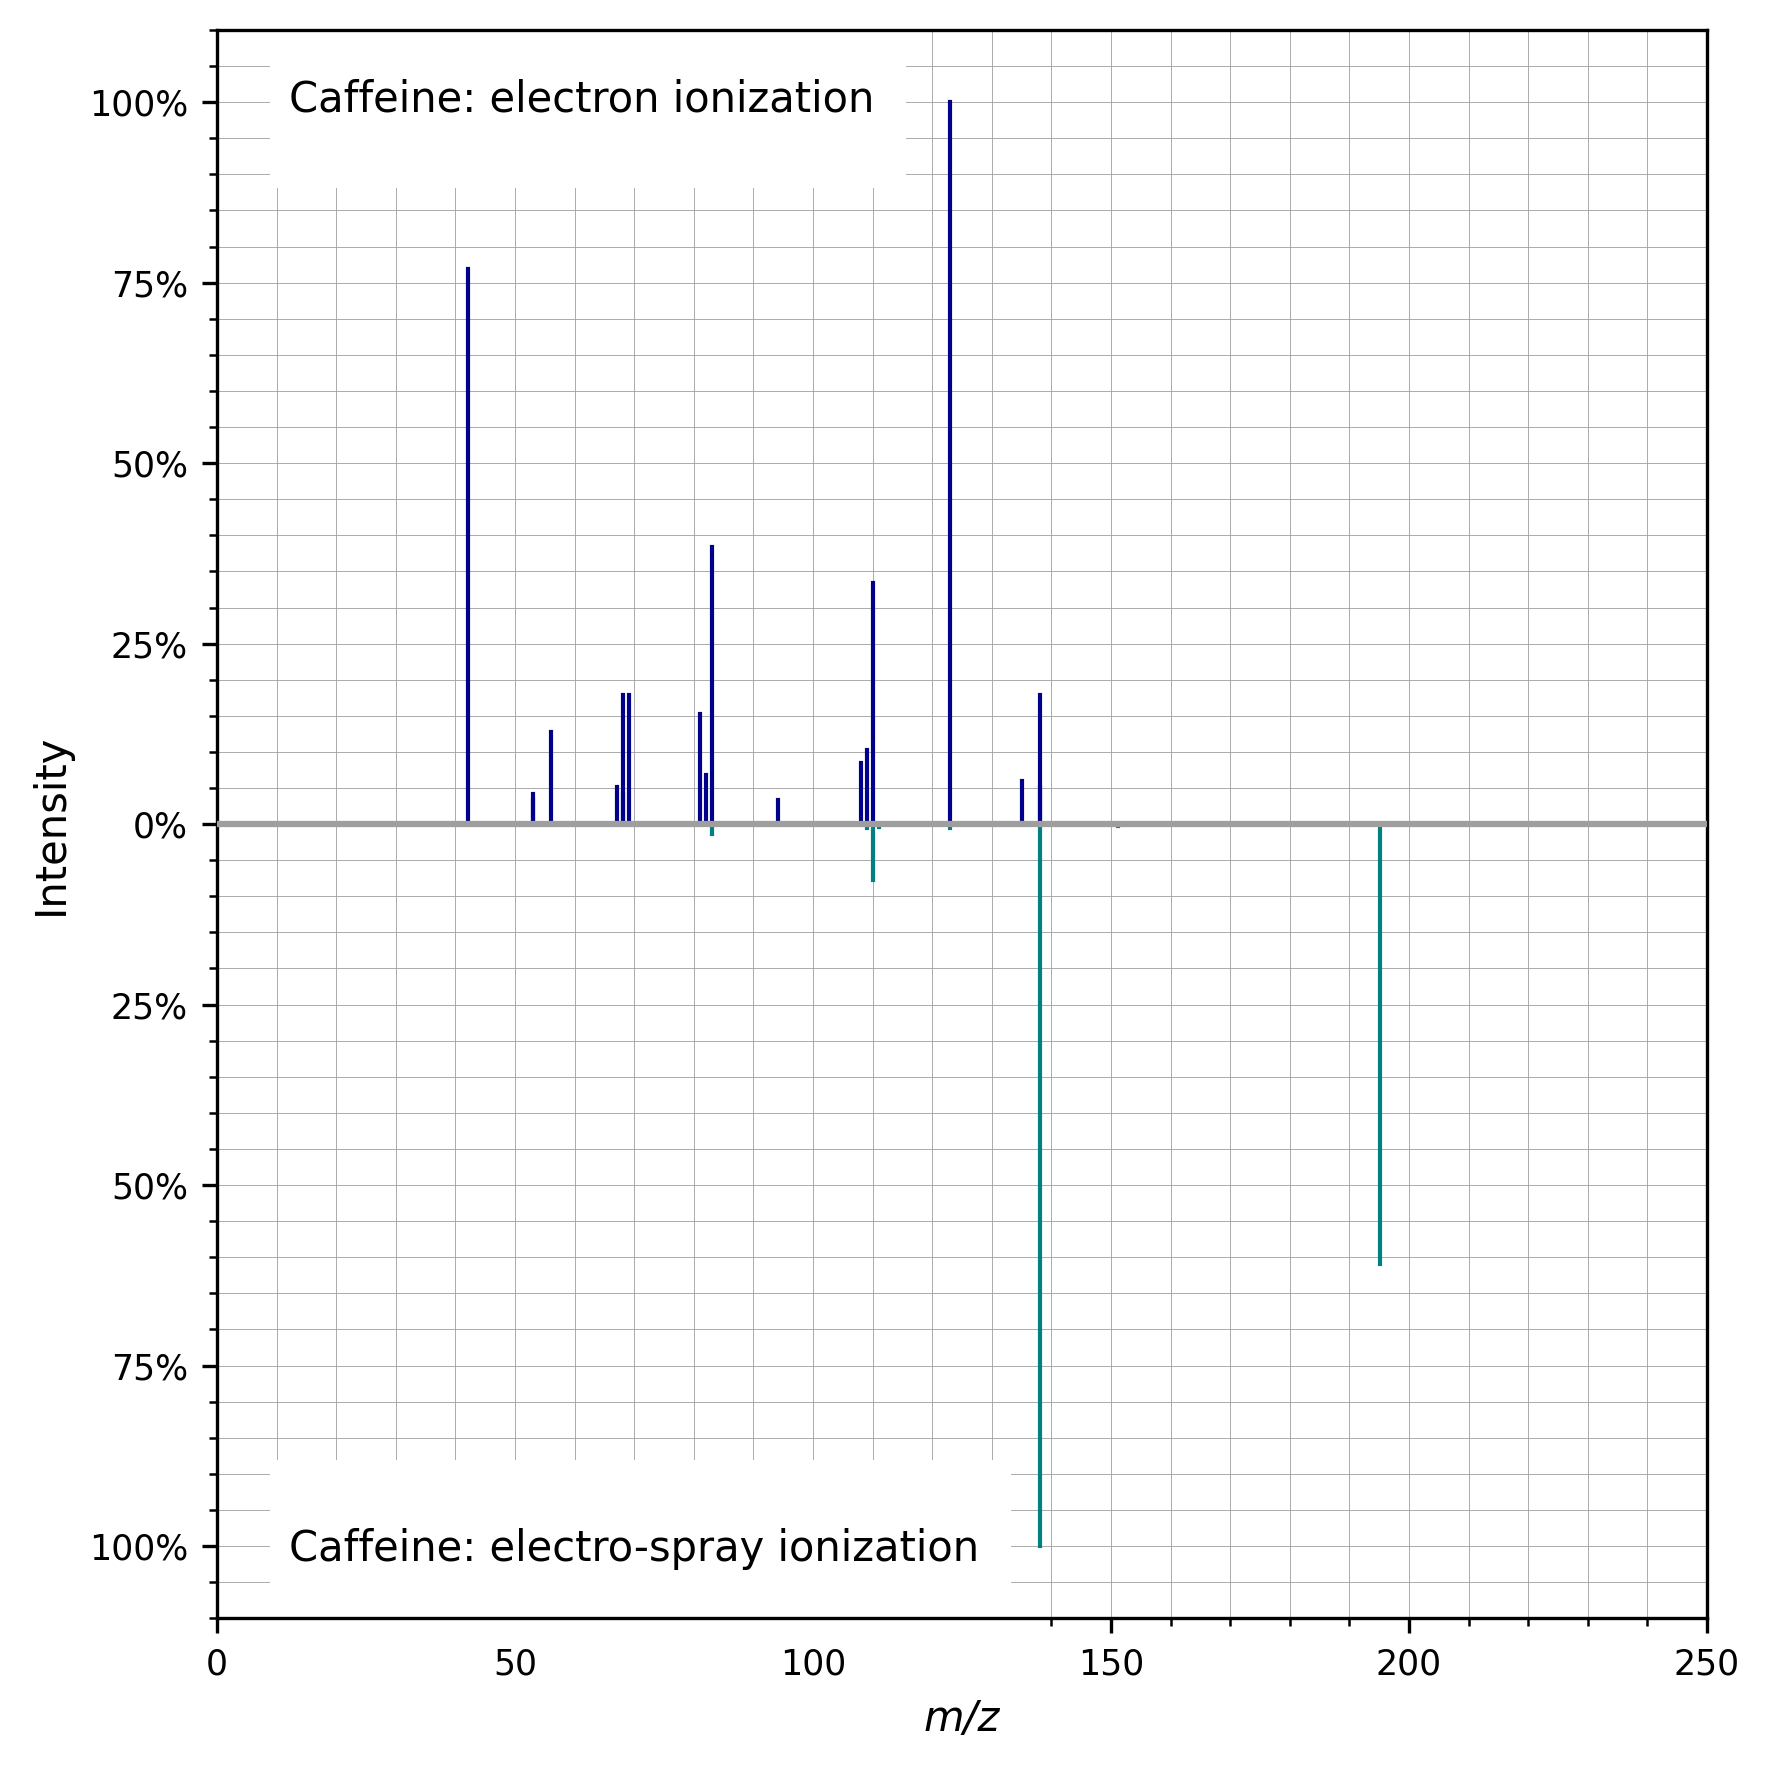

In [63]:
import matchms as mms
df = df[df.smiles == 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C']
# df.instrument_type

# a = df.sample(1).iloc[0]
a = df.loc[21746]
# b = df.sample(1).iloc[0]
b = df.loc[21776]
print(a)
print(b)

def to_spectrum(a):
  mz = np.array(list(map(float, a.mzs.split(','))))
  ints = np.array(list(map(float, a.intensities.split(','))))
  d = a.to_dict()
  mode = "electron ionization" if a.instrument_type == 'QTOF' else "electro-spray ionization"
  d['compound_name'] = f'\nCaffeine: {mode} \n'
  sp = mms.Spectrum(mz=mz, intensities=ints, metadata=d)
  return sp

a = to_spectrum(a)
b = to_spectrum(b)

f = plt.figure(figsize=(6,6), dpi=300)
mms.plotting.plot_spectra_mirror(a, b, ax=plt.gca())
plt.title(None)
plt.xlim(0, 250)
plt.tight_layout()
plt.savefig(output_dir / "caffeine_msms_different.png")

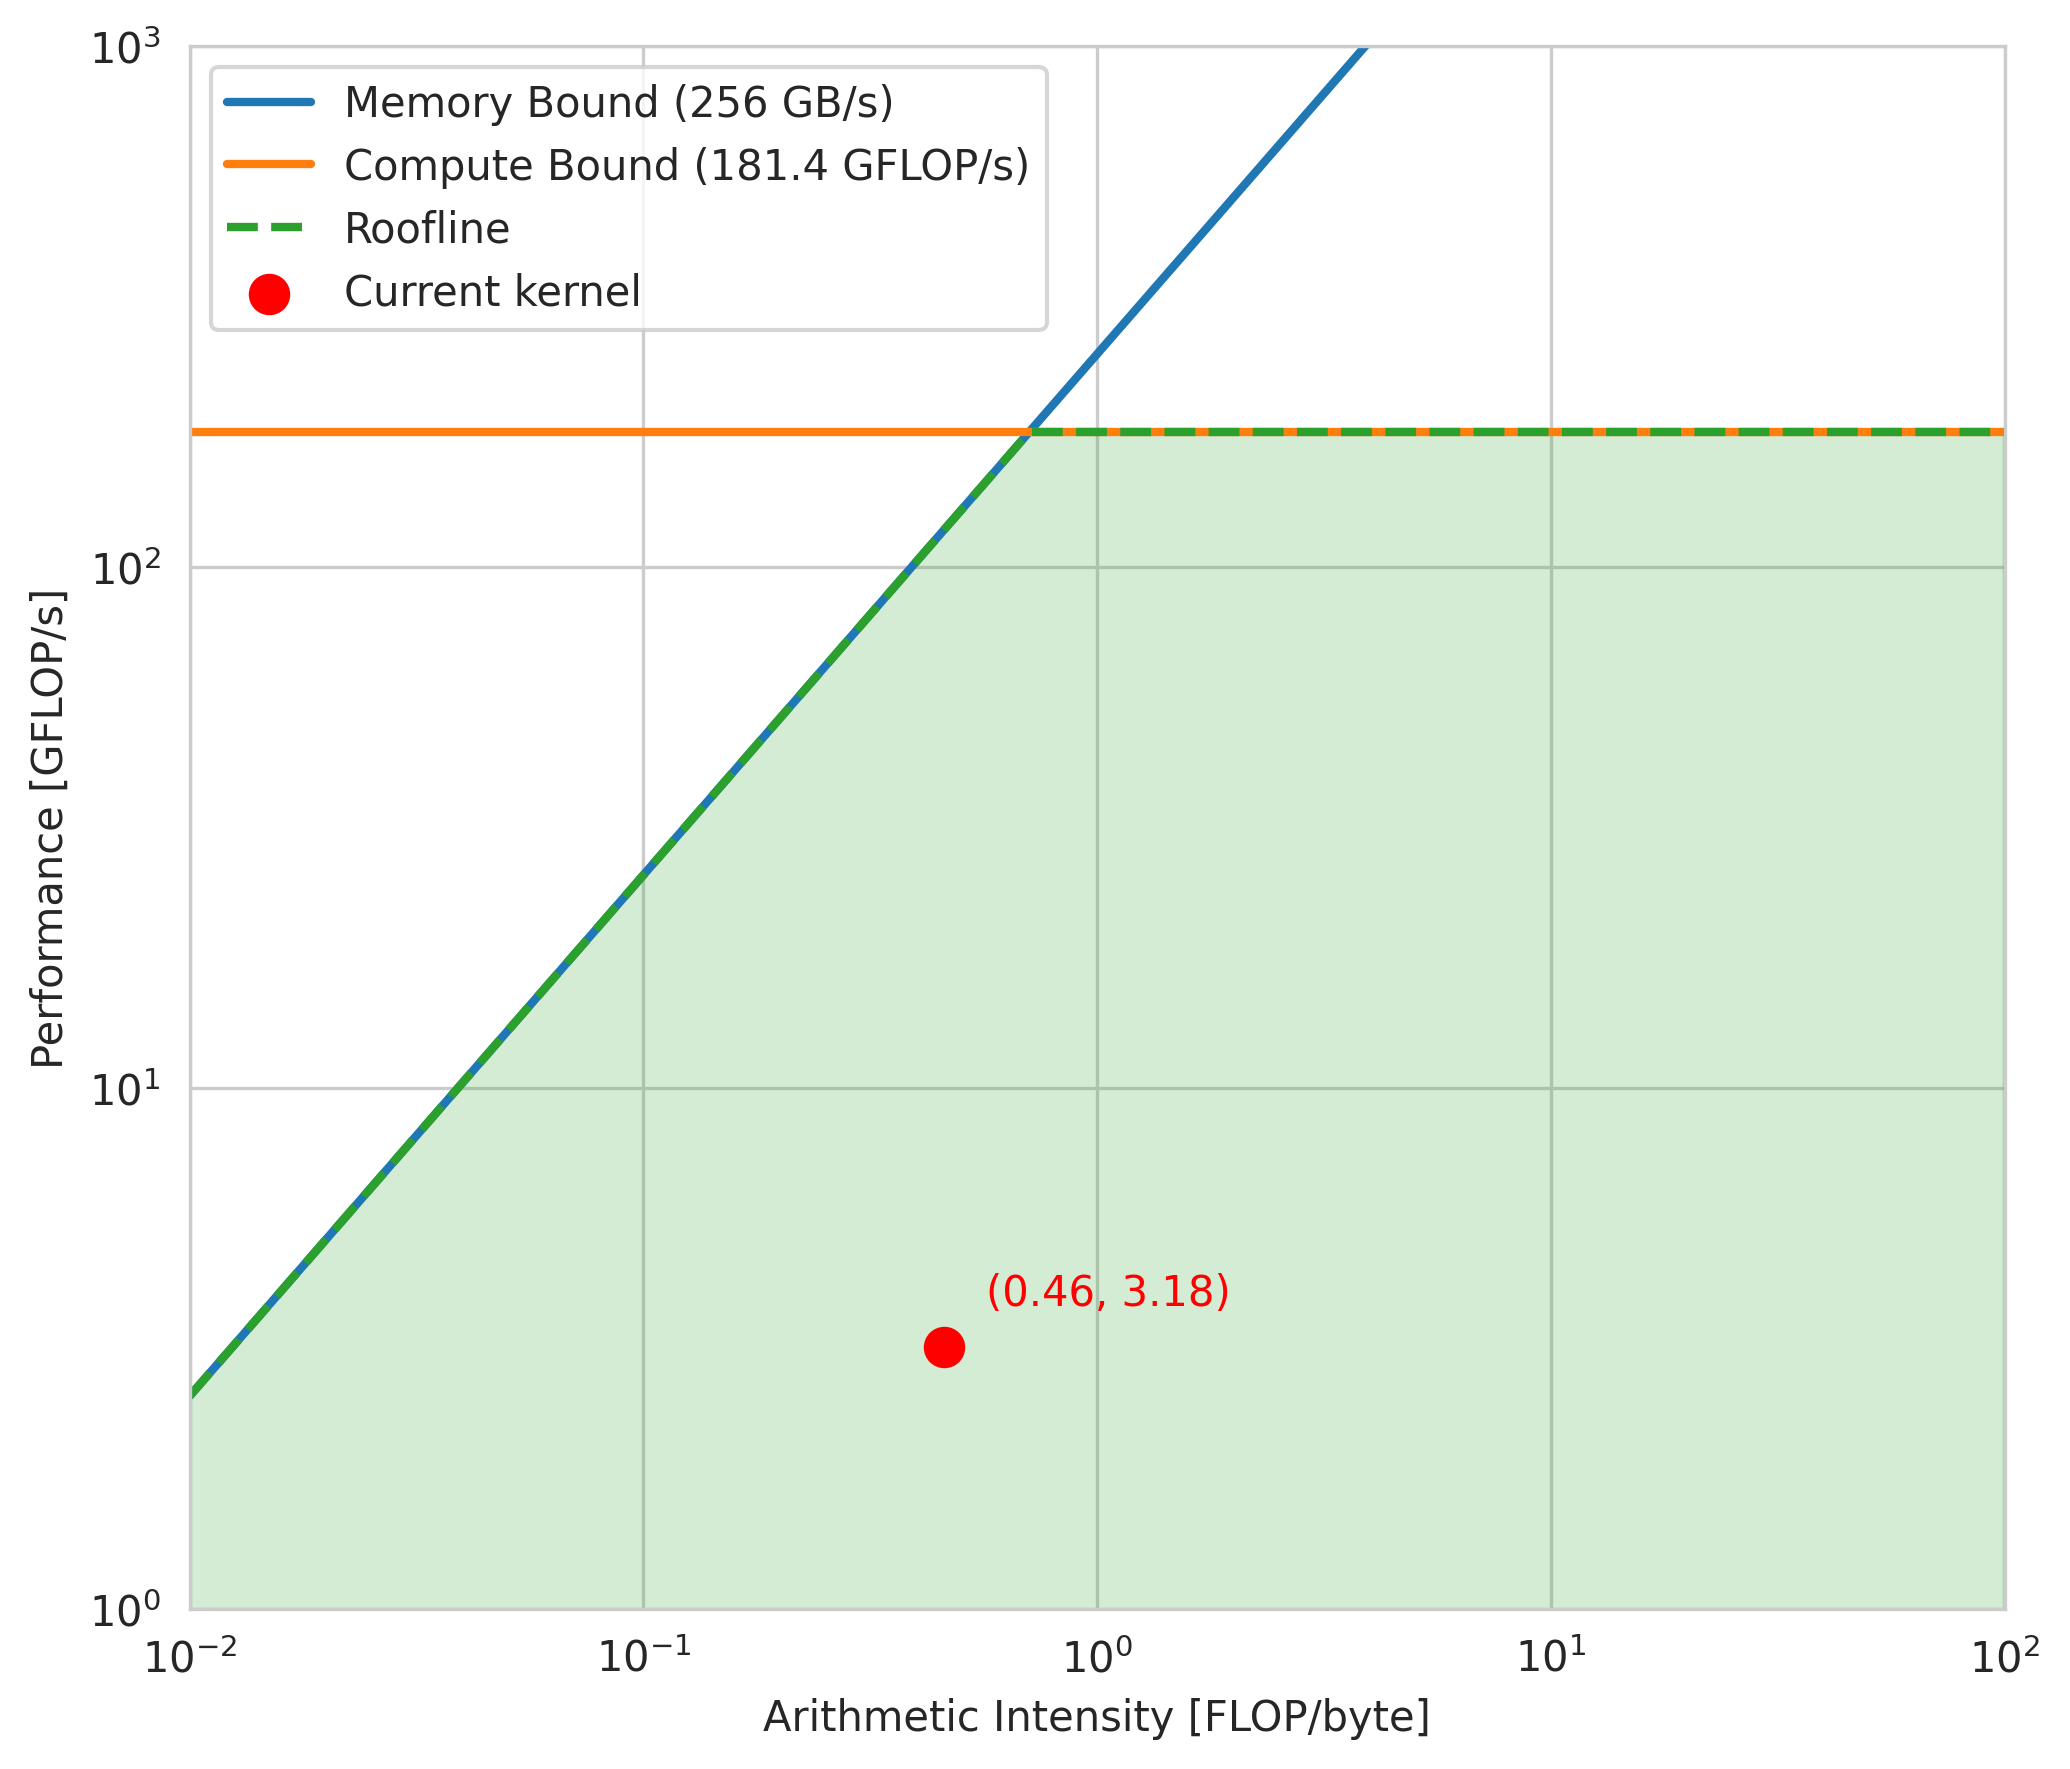

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set_style(style="whitegrid")

# Hardware specs
peak_perf = 181.4  # GFLOP/s (FP64)
bandwidth = 256.0  # GB/s

# X axis: Arithmetic intensity (FLOP/byte)
x = np.logspace(-2, 2, 500)  # from 0.01 to 100

# Rooflines
y_bandwidth = bandwidth * x  # Memory bound
y_peak = np.full_like(x, peak_perf)  # Compute bound

# # Plot
plt.figure(figsize=(7,6), dpi=300)
plt.plot(x, y_bandwidth, label="Memory Bound (256 GB/s)", color="C0", linewidth=2)
plt.plot(x, y_peak, label="Compute Bound (181.4 GFLOP/s)", color="C1", linewidth=2)
plt.fill_between(x, 0, np.minimum(y_bandwidth, y_peak), color="C2", alpha=0.2)

# Highlight roofline
roofline = np.minimum(y_bandwidth, y_peak)
plt.plot(x, roofline, color="C2", linestyle="--", linewidth=2, label="Roofline")

# Add the data point
ai_point = 0.46
perf_point = 3_177_953_092.10 / 1e9  # Convert to GFLOP/s
plt.scatter([ai_point], [perf_point], color="red", s=80, zorder=5, label="Current kernel")
plt.annotate(f"({ai_point:.2f}, {perf_point:.2f})",
             (ai_point, perf_point),
             textcoords="offset points",
             xytext=(10,10),
             ha='left',
             color="red")

# Axes settings
plt.xscale("log")
plt.yscale("log")
plt.xlim(0.01, 100)
plt.ylim(1, 1000)
plt.xlabel("Arithmetic Intensity [FLOP/byte]")
plt.ylabel("Performance [GFLOP/s]")
# plt.title("Roofline Chart: RTX4060 Laptop GPU (FP64)")
plt.legend()
plt.tight_layout()
plt.savefig(output_dir / "roofline.png")
plt.show()

,structure,nat,nprim,maxl,max_nnl,mean_nnl,max_nsh,cpu_time,gpu_type,ncpu
0,alkane_64,192,6,1,30,20,2,27.576135,i9-14900HX,1
1,alkane_128,384,6,1,30,21,2,58.374596,i9-14900HX,1
2,alkane_256,768,6,1,30,21,2,127.952297,i9-14900HX,1
3,103l-hydrolase,1404,6,2,310,99,3,1575.728317,i9-14900HX,1
4,alkane_512,1536,6,1,30,21,2,279.308855,i9-14900HX,1
5,alkane_1024,3072,6,1,30,21,2,704.700987,i9-14900HX,1
6,alkane_2048,6144,6,1,30,21,2,1870.311269,i9-14900HX,1
7,alkane_64,192,6,1,30,20,2,16.223582,i9-14900HX,2
8,alkane_128,384,6,1,30,21,2,32.757154,i9-14900HX,2
9,alkane_256,768,6,1,30,21,2,77.568121,i9-14900HX,2


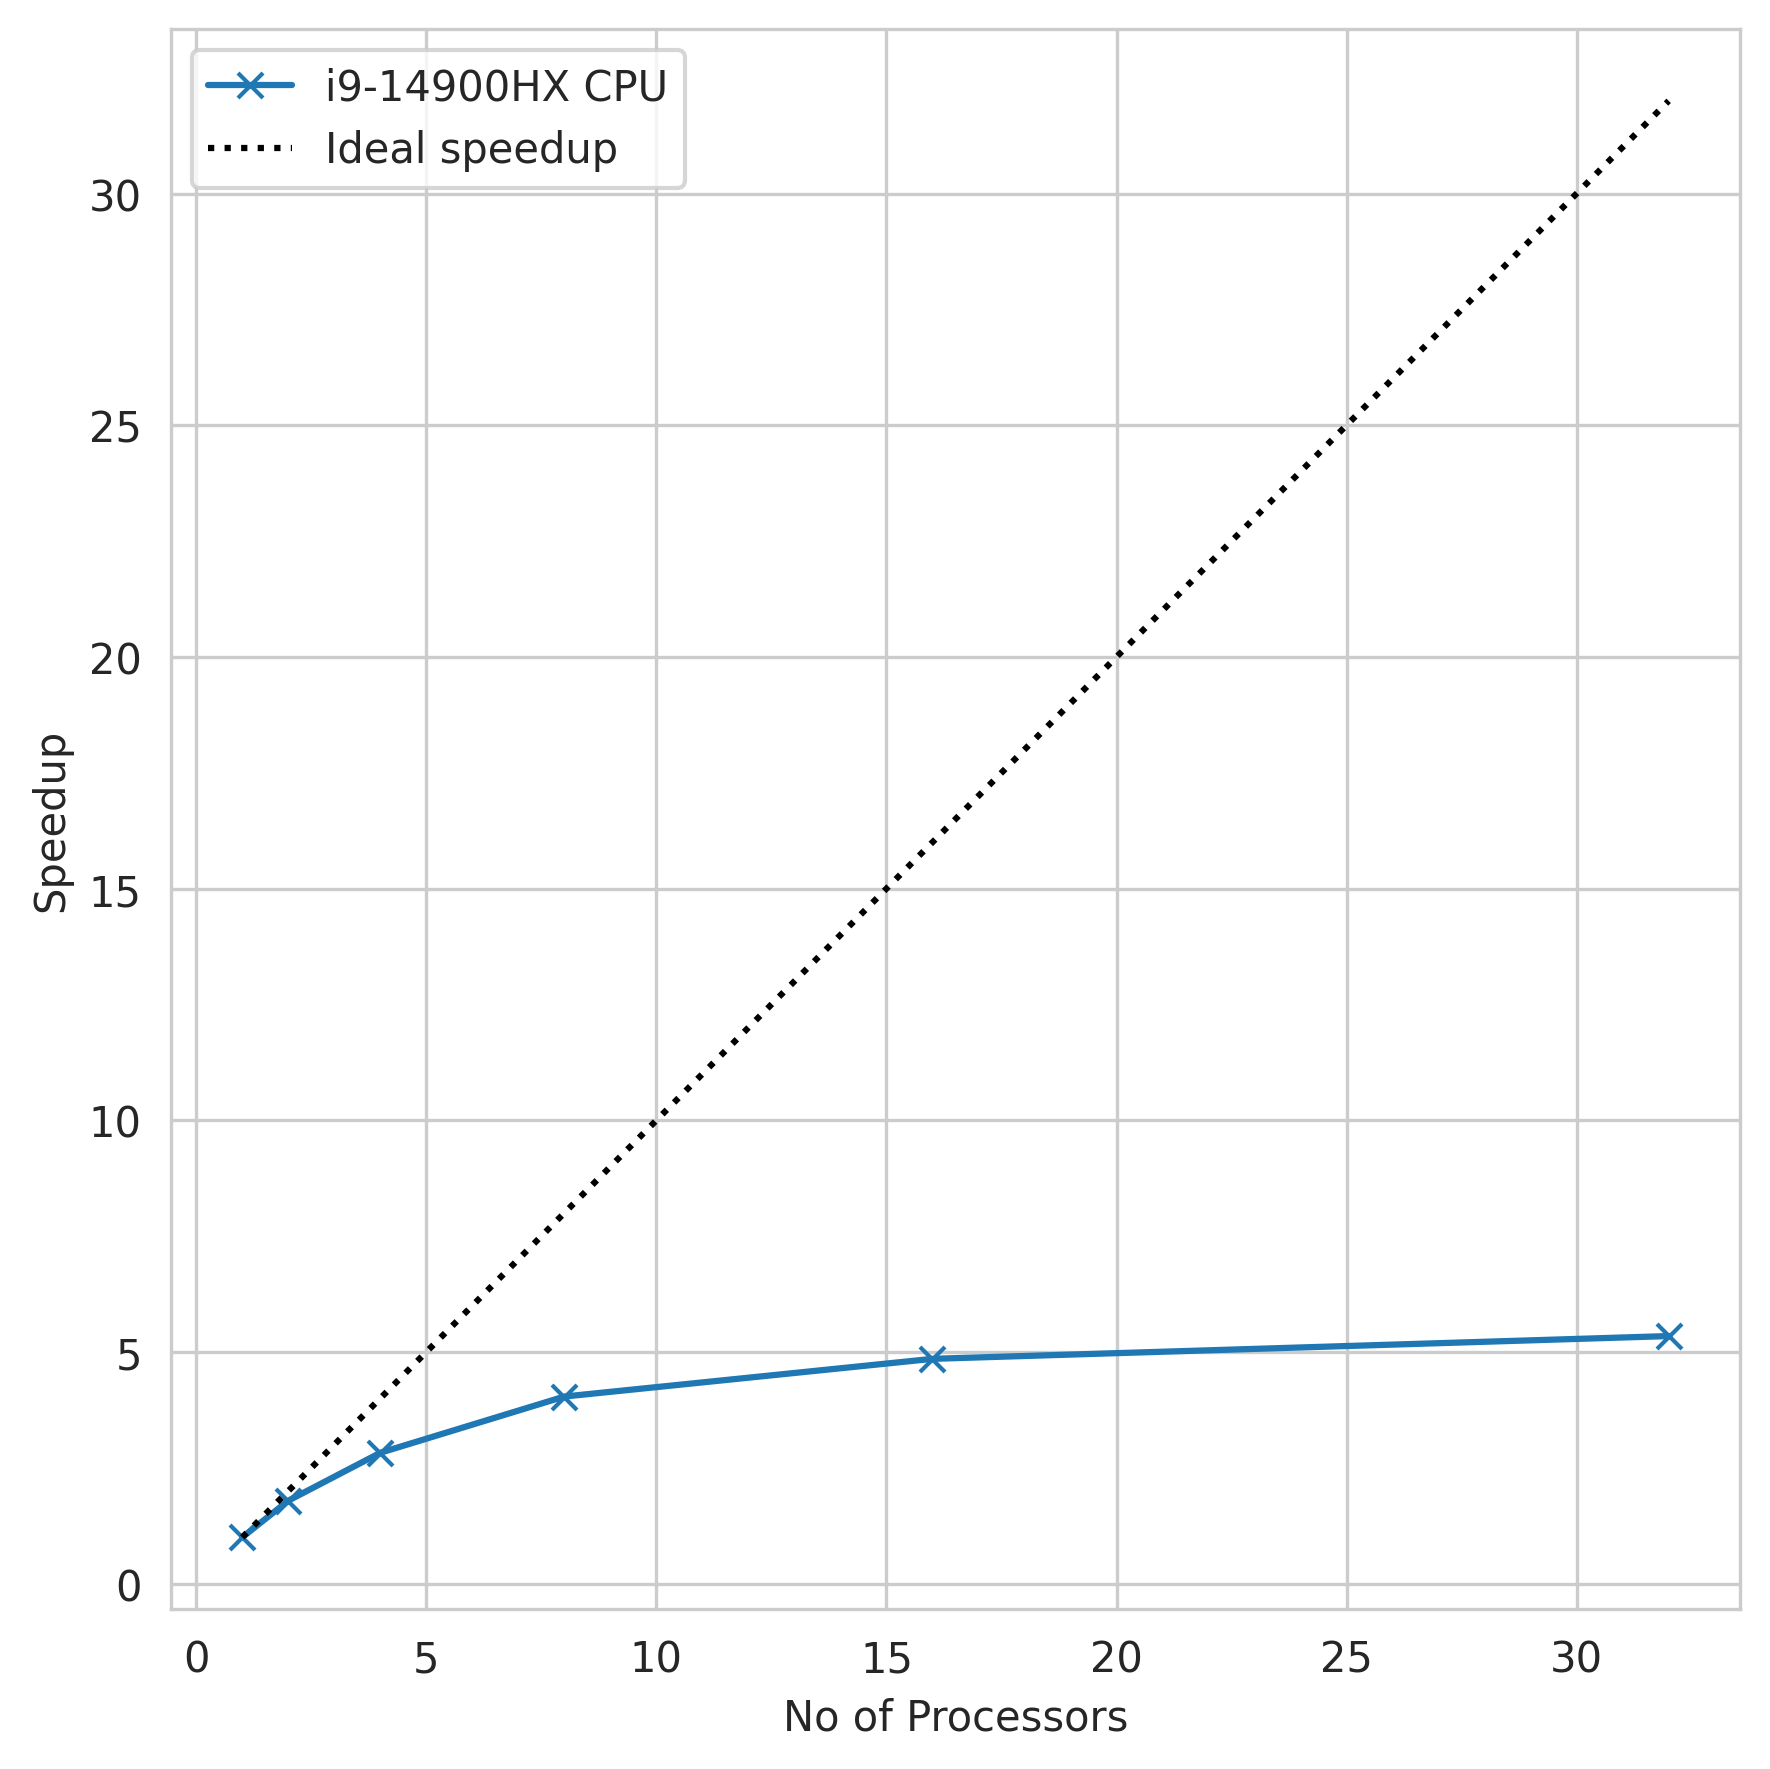

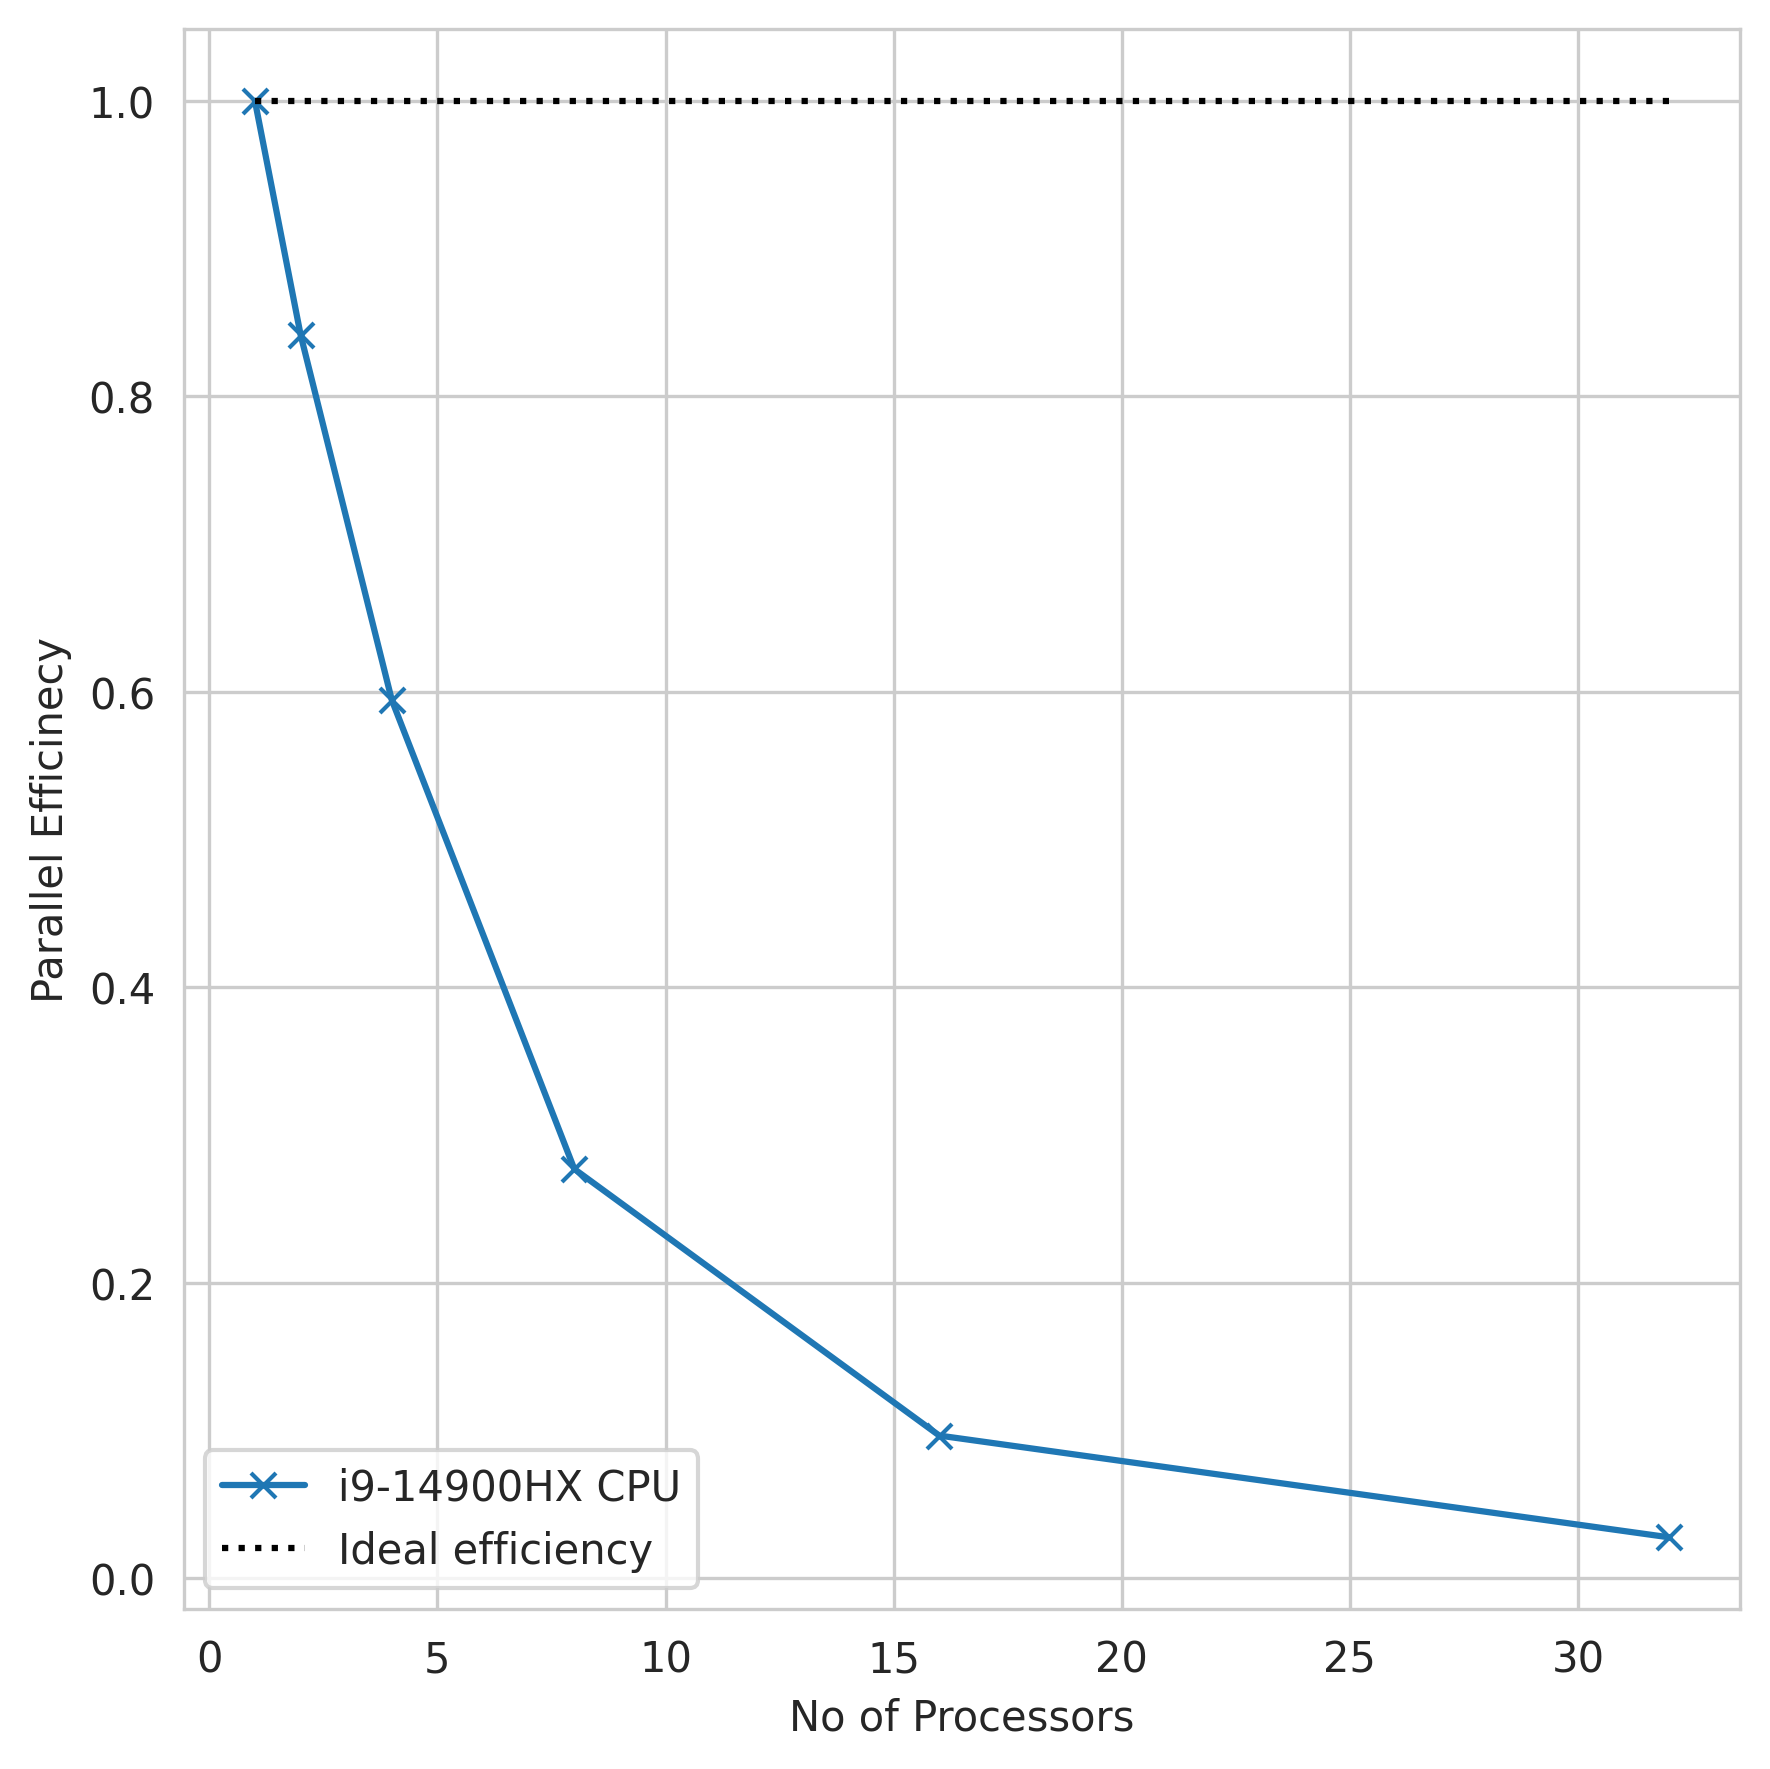

In [8]:
cpu_data = []
for ncpu in [1, 2, 4, 8, 16, 32]:
    df = pd.read_csv(f'notes/data/i9-14900HX/{ncpu}cpu.csv')
    df['gpu_type'] = 'i9-14900HX'
    df['ncpu'] = ncpu
    cpu_data.append(df)

df = pd.concat(cpu_data, ignore_index=True)
display(df)

# plt.figure(figsize=(5,5), dpi=200)
def make_strong_scaling(df):
  df = df[~df.structure.str.contains('alkane')].reset_index(drop=True)
  speedup = df.cpu_time.loc[0].item() / df.cpu_time.values 
  ideal_speedup = df.ncpu.values
  plt.plot(df['ncpu'].values, speedup, 'x-', label='i9-14900HX CPU')
  plt.plot(df['ncpu'].values, ideal_speedup, ':k', label="Ideal speedup")
  plt.xlabel("No of Processors");
  plt.ylabel("Speedup");
  plt.grid(True)
  plt.legend()

def make_weak_scaling_eff(df):
  df = df[df.structure.str.contains('alkane')].reset_index(drop=True)
  probsize = df.structure.str.slice(7).astype(int)
  df['probsize'] = probsize
  df = df[df.probsize / 64 == df['ncpu']]
  speedup = df.cpu_time.loc[0].item() / df.cpu_time.values
  plt.plot(df['ncpu'].values, speedup, 'x-', label='i9-14900HX CPU')
  plt.plot(df['ncpu'].values, np.ones_like(df['ncpu'].values), ':k', label="Ideal efficiency")
  plt.ylabel("Parallel Efficinecy")
  plt.xlabel("No of Processors")
  plt.grid(True)
  plt.legend()

# plt.subplot(121)

output_dir = Path(output_dir)


plt.figure(figsize=(6,6),dpi=300)
sns.set_style("whitegrid")
make_strong_scaling(df)
plt.tight_layout()
plt.savefig(output_dir / 'cpu_scaling_strong.png')
# plt.subplot(122)


plt.figure(figsize=(6,6),dpi=300)
sns.set_style("whitegrid")
make_weak_scaling_eff(df)
plt.tight_layout()
plt.savefig(output_dir / 'cpu_scaling_weak.png')

# plt.show()

In [9]:
# cpu_data = []
# for ncpu in [1, 2, 4, 8, 16, 32]:
#     df = pd.read_csv(f'notes/data/i9-14900HX-no-atomic/{ncpu}cpu.csv')
#     df['gpu_type'] = 'i9-14900HX (no atomics)'
#     df['ncpu'] = ncpu
#     cpu_data.append(df)

# df = pd.concat(cpu_data, ignore_index=True)
# df

In [10]:
# # plt.figure(figsize=(5,5), dpi=200)
# def make_strong_scaling(df):
#   df = df[~df.structure.str.contains('alkane')].reset_index(drop=True)
#   speedup = df.cpu_time.loc[0].item() / df.cpu_time.values 
#   ideal_speedup = df.ncpu.values
#   plt.plot(df['ncpu'].values, speedup, 'x-', label='i9-14900HX CPU (no atomics)')
#   plt.plot(df['ncpu'].values, ideal_speedup, ':k', label="Perfect speedup")
#   plt.xlabel("No of Processors");
#   plt.ylabel("Speedup");
#   plt.grid(True)
#   plt.legend()

# def make_weak_scaling_eff(df):
#   df = df[df.structure.str.contains('alkane')].reset_index(drop=True)
#   probsize = df.structure.str.slice(7).astype(int)
#   df['probsize'] = probsize
#   df = df[df.probsize / 64 == df['ncpu']]
#   display(df)
#   speedup = df.cpu_time.iloc[0].item() / df.cpu_time.values
#   plt.plot(df['ncpu'].values, speedup, 'x-', label='i9-14900HX CPU (no atomics)')
#   plt.plot(df['ncpu'].values, np.ones_like(df['ncpu'].values), ':k', label="Perfect efficiency")
#   plt.ylabel("Parallel Efficinecy")
#   plt.xlabel("No of Processors")
#   plt.grid(True)
#   plt.legend()

# # plt.subplot(121)


# plt.figure(figsize=(6,6),dpi=300)
# sns.set_style("whitegrid")
# make_strong_scaling(df)
# plt.savefig(output_dir / 'cpu_scaling_strong_no_atomics.png')
# # plt.subplot(122)

# plt.figure(figsize=(6,6),dpi=300)
# sns.set_style("whitegrid")
# make_weak_scaling_eff(df)
# plt.savefig(output_dir / 'cpu_scaling_weak_no_atomics.png')

# # plt.show()

In [11]:
all_data = []
df = pd.read_csv(f'notes/data/RTX4060/gpu.csv')
df['gpu_type'] = 'RTX4060'
all_data.append(df)

# for ncpu in [1, 2, 4, 8, 16, 32]:
#     df = pd.read_csv(f'notes/data/v100/{ncpu}cpu.csv')
#     df['gpu_type'] = 'v100'
#     df['ncpu'] = ncpu
#     all_data.append(df)

df = pd.read_csv(f'notes/data/RTX4090/gpu.csv')
df['gpu_type'] = 'RTX4090'
all_data.append(df)

df = pd.concat(all_data, ignore_index=True)

In [12]:
df

,structure,nat,nprim,maxl,max_nnl,mean_nnl,max_nsh,cpu_time,gpu_gb_in,gpu_gb_out,gpu_gb_total,gpu_between_atoms,gpu_in_atoms,gpu_time,gpu_transfer_time,gpu_type
0,GLU,29,6,1,28,14,2,11.985369,0.000453,0.000444,0.000896,10.739712,2.131936,12.871648,0.954560,RTX4060
1,alkane_64,192,6,1,30,20,2,8.414220,0.013026,0.012976,0.026002,9.414656,1.933568,11.348224,6.645632,RTX4060
2,alkane_128,384,6,1,30,21,2,14.909392,0.052005,0.051905,0.103909,17.855583,2.703648,20.559231,21.178593,RTX4060
3,dna,387,6,2,165,69,3,59.047182,0.232068,0.231803,0.463871,212.961273,9.908224,222.869492,87.494461,RTX4060
4,101d-netropsin-and-dna,556,6,2,484,203,3,105.978783,0.479133,0.478153,0.957286,383.203156,10.908800,394.111969,166.830170,RTX4060
5,alkane_256,768,6,1,30,21,2,32.171431,0.207819,0.207618,0.415437,50.085888,5.079040,55.164928,90.081284,RTX4060
6,1lyz-lysozyme,1102,6,2,311,99,3,210.940091,1.749900,1.748891,3.498791,541.932922,15.230976,557.163879,575.938538,RTX4060
7,103l-hydrolase,1404,6,2,309,99,3,320.774930,2.816439,2.815150,5.631588,673.622864,17.464289,691.087158,962.728943,RTX4060
8,alkane_512,1536,6,1,30,21,2,86.739008,0.830875,0.830472,1.661347,71.779327,6.709184,78.488510,292.157104,RTX4060
9,alkane_1024,3072,6,1,30,21,2,290.792890,3.322695,3.321889,6.644584,137.043198,11.519104,148.562302,1141.643188,RTX4060


<Figure size 1800x1800 with 0 Axes>

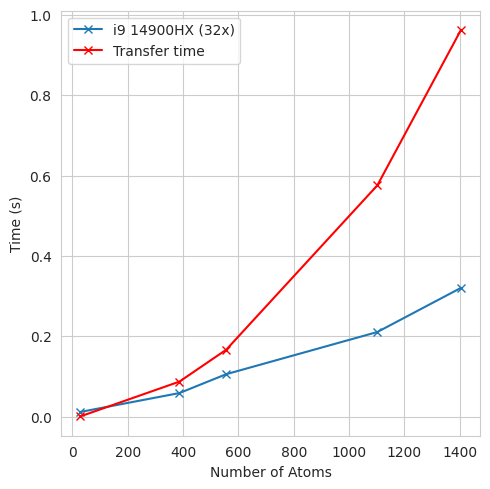

In [13]:
def make_process_on_cpu_vs_copy_to_gpu(df):

  mask = ~df.structure.str.contains('alkan') & df.gpu_type.str.contains('RTX4060')
  x = df[mask].nat
  y = df[mask].gpu_transfer_time / 1000
  z = df[mask].cpu_time / 1000
  w = df[mask].gpu_time / 1000
  plt.figure(figsize=(5, 5))
  sns.set_style("whitegrid")
  plt.plot(x,z, 'x-', label='i9 14900HX (32x)')
  plt.plot(x,y, 'x-r', label='Transfer time')
  plt.xlabel('Number of Atoms')
  plt.ylabel('Time (s)')
  plt.grid(True)
  plt.legend()


plt.figure(figsize=(6,6),dpi=300)
sns.set_style("whitegrid")
make_process_on_cpu_vs_copy_to_gpu(df)
plt.tight_layout()
plt.savefig(output_dir / 'cpu_gpu_transfer_time.png')

In [14]:
df

,structure,nat,nprim,maxl,max_nnl,mean_nnl,max_nsh,cpu_time,gpu_gb_in,gpu_gb_out,gpu_gb_total,gpu_between_atoms,gpu_in_atoms,gpu_time,gpu_transfer_time,gpu_type
0,GLU,29,6,1,28,14,2,11.985369,0.000453,0.000444,0.000896,10.739712,2.131936,12.871648,0.954560,RTX4060
1,alkane_64,192,6,1,30,20,2,8.414220,0.013026,0.012976,0.026002,9.414656,1.933568,11.348224,6.645632,RTX4060
2,alkane_128,384,6,1,30,21,2,14.909392,0.052005,0.051905,0.103909,17.855583,2.703648,20.559231,21.178593,RTX4060
3,dna,387,6,2,165,69,3,59.047182,0.232068,0.231803,0.463871,212.961273,9.908224,222.869492,87.494461,RTX4060
4,101d-netropsin-and-dna,556,6,2,484,203,3,105.978783,0.479133,0.478153,0.957286,383.203156,10.908800,394.111969,166.830170,RTX4060
5,alkane_256,768,6,1,30,21,2,32.171431,0.207819,0.207618,0.415437,50.085888,5.079040,55.164928,90.081284,RTX4060
6,1lyz-lysozyme,1102,6,2,311,99,3,210.940091,1.749900,1.748891,3.498791,541.932922,15.230976,557.163879,575.938538,RTX4060
7,103l-hydrolase,1404,6,2,309,99,3,320.774930,2.816439,2.815150,5.631588,673.622864,17.464289,691.087158,962.728943,RTX4060
8,alkane_512,1536,6,1,30,21,2,86.739008,0.830875,0.830472,1.661347,71.779327,6.709184,78.488510,292.157104,RTX4060
9,alkane_1024,3072,6,1,30,21,2,290.792890,3.322695,3.321889,6.644584,137.043198,11.519104,148.562302,1141.643188,RTX4060


In [3]:
all_data = []
df = pd.read_csv(f'notes/data/i9-14900HX/32allcpu.csv')
df['processor'] = 'i9-14900HX (32x)'
df['time'] = df['cpu_time']
all_data.append(df)

df = pd.read_csv(f'notes/data/Tesla_V100-SXM2-32GB/gpu.csv')
df['processor'] = 'Tesla_V100-SXM2-32GB'
df['time'] = df['gpu_time']
all_data.append(df)

df = pd.read_csv(f'notes/data/H100_80GB_HBM3/gpu.csv')
df['processor'] = 'H100_80GB_HBM3'
df['time'] = df['gpu_time']
all_data.append(df)

df = pd.read_csv(f'notes/data/RTX4090/gpu.csv')
df['processor'] = 'RTX4090'
df['time'] = df['gpu_time']
all_data.append(df)
df = pd.concat(all_data, ignore_index=True)
df['processor'] = df.processor.str.replace('-',' ').str.replace('_',' ')
df

,structure,nat,nprim,maxl,max_nnl,mean_nnl,max_nsh,cpu_time,processor,time,gpu_gb_in,gpu_gb_out,gpu_gb_total,gpu_between_atoms,gpu_in_atoms,gpu_time,gpu_transfer_time
0,GLU,29,6,1,28,14,2,12.926781,i9 14900HX (32x),12.926781,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,alkane_64,192,6,1,30,20,2,7.539956,i9 14900HX (32x),7.539956,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,alkane_128,384,6,1,30,21,2,12.868747,i9 14900HX (32x),12.868747,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,dna,387,6,2,166,69,3,57.028620,i9 14900HX (32x),57.028620,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,alkane_256,768,6,1,30,21,2,28.582178,i9 14900HX (32x),28.582178,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1lyz-lysozyme,1102,6,2,308,99,3,231.494165,i9 14900HX (32x),231.494165,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,103l-hydrolase,1404,6,2,312,99,3,324.561817,i9 14900HX (32x),324.561817,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,alkane_512,1536,6,1,30,21,2,83.130808,i9 14900HX (32x),83.130808,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,alkane_1024,3072,6,1,30,21,2,285.172123,i9 14900HX (32x),285.172123,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,alkane_2048,6144,6,1,30,21,2,1457.929060,i9 14900HX (32x),1457.929060,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,structure,nat,nprim,maxl,max_nnl,mean_nnl,max_nsh,cpu_time,processor,time,gpu_gb_in,gpu_gb_out,gpu_gb_total,gpu_between_atoms,gpu_in_atoms,gpu_time,gpu_transfer_time,relative
0,GLU,29,6,1,28,14,2,12.926781,i9 14900HX (32x),12.926781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
10,GLU,29,6,1,28,14,2,207.096718,Tesla V100 SXM2 32GB,7.997440,0.000453,0.000444,0.000896,7.103488,0.893952,7.997440,1.402880,1.616365
20,GLU,29,6,1,28,14,2,25.599215,H100 80GB HBM3,5.525504,0.000453,0.000444,0.000896,5.177216,0.348288,5.525504,1.093344,2.339475
30,GLU,29,6,1,28,14,2,84.487865,RTX4090,11.924320,0.000453,0.000444,0.000896,11.482048,0.442272,11.924320,1.218752,1.084069


,structure,nat,nprim,maxl,max_nnl,mean_nnl,max_nsh,cpu_time,processor,time,gpu_gb_in,gpu_gb_out,gpu_gb_total,gpu_between_atoms,gpu_in_atoms,gpu_time,gpu_transfer_time,relative
3,dna,387,6,2,166,69,3,57.028620,i9 14900HX (32x),57.028620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
13,dna,387,6,2,165,69,3,306.009300,Tesla V100 SXM2 32GB,15.347712,0.232067,0.231803,0.463871,13.897728,1.449984,15.347712,196.754425,3.715773
23,dna,387,6,2,165,69,3,44.083036,H100 80GB HBM3,4.376608,0.232068,0.231803,0.463871,3.571200,0.805408,4.376608,84.105629,13.030324
33,dna,387,6,2,165,69,3,118.418229,RTX4090,11.824896,0.232068,0.231803,0.463871,10.613664,1.211232,11.824896,186.631943,4.822759


,structure,nat,nprim,maxl,max_nnl,mean_nnl,max_nsh,cpu_time,processor,time,gpu_gb_in,gpu_gb_out,gpu_gb_total,gpu_between_atoms,gpu_in_atoms,gpu_time,gpu_transfer_time,relative
5,1lyz-lysozyme,1102,6,2,308,99,3,231.494165,i9 14900HX (32x),231.494165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
15,1lyz-lysozyme,1102,6,2,311,99,3,940.848039,Tesla V100 SXM2 32GB,37.256195,1.7499,1.748891,3.498791,35.352577,1.903616,37.256195,1787.806641,6.213575
25,1lyz-lysozyme,1102,6,2,309,99,3,239.119671,H100 80GB HBM3,10.338048,1.7499,1.748891,3.498791,9.492480,0.845568,10.338048,659.180969,22.392444
35,1lyz-lysozyme,1102,6,2,311,99,3,239.951641,RTX4090,28.091455,1.7499,1.748891,3.498791,26.539007,1.552448,28.091455,1244.322021,8.240732


,structure,nat,nprim,maxl,max_nnl,mean_nnl,max_nsh,cpu_time,processor,time,gpu_gb_in,gpu_gb_out,gpu_gb_total,gpu_between_atoms,gpu_in_atoms,gpu_time,gpu_transfer_time,relative
6,103l-hydrolase,1404,6,2,312,99,3,324.561817,i9 14900HX (32x),324.561817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
16,103l-hydrolase,1404,6,2,313,99,3,1202.823509,Tesla V100 SXM2 32GB,45.225983,2.816439,2.81515,5.631588,43.544575,1.681408,45.225983,2371.649414,7.176446
26,103l-hydrolase,1404,6,2,312,99,3,338.086432,H100 80GB HBM3,12.072000,2.816439,2.81515,5.631588,11.214592,0.857408,12.072000,1044.699097,26.885505
36,103l-hydrolase,1404,6,2,311,99,3,339.549190,RTX4090,34.475712,2.816439,2.81515,5.631589,32.780991,1.694720,34.475712,2008.862305,9.414217


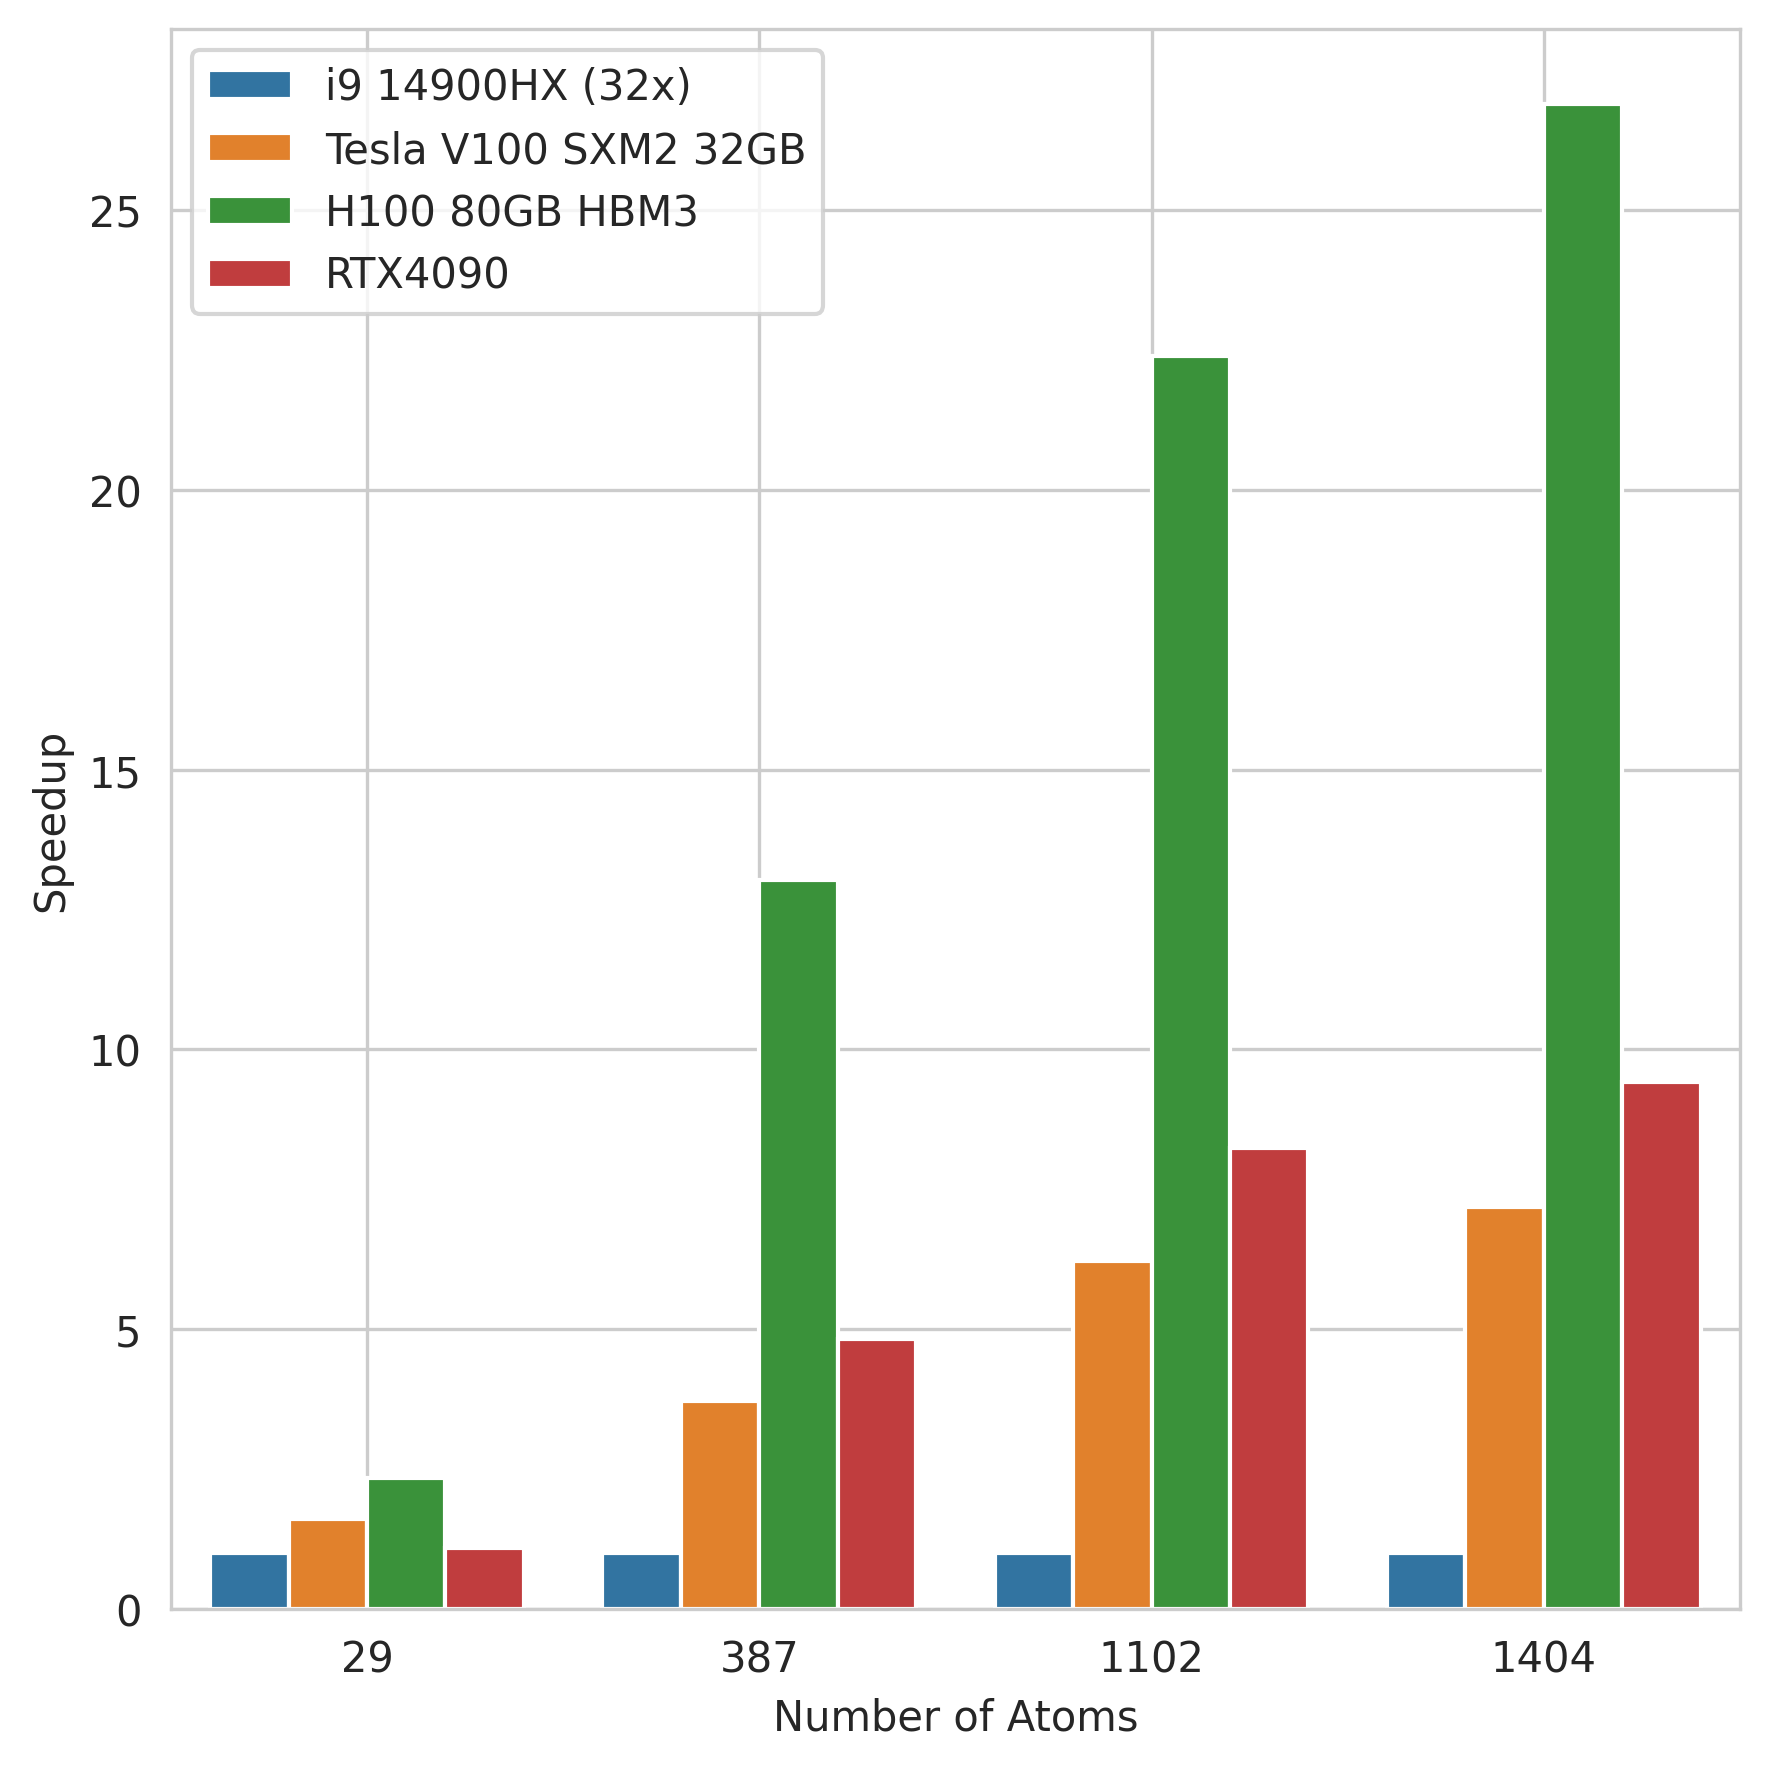

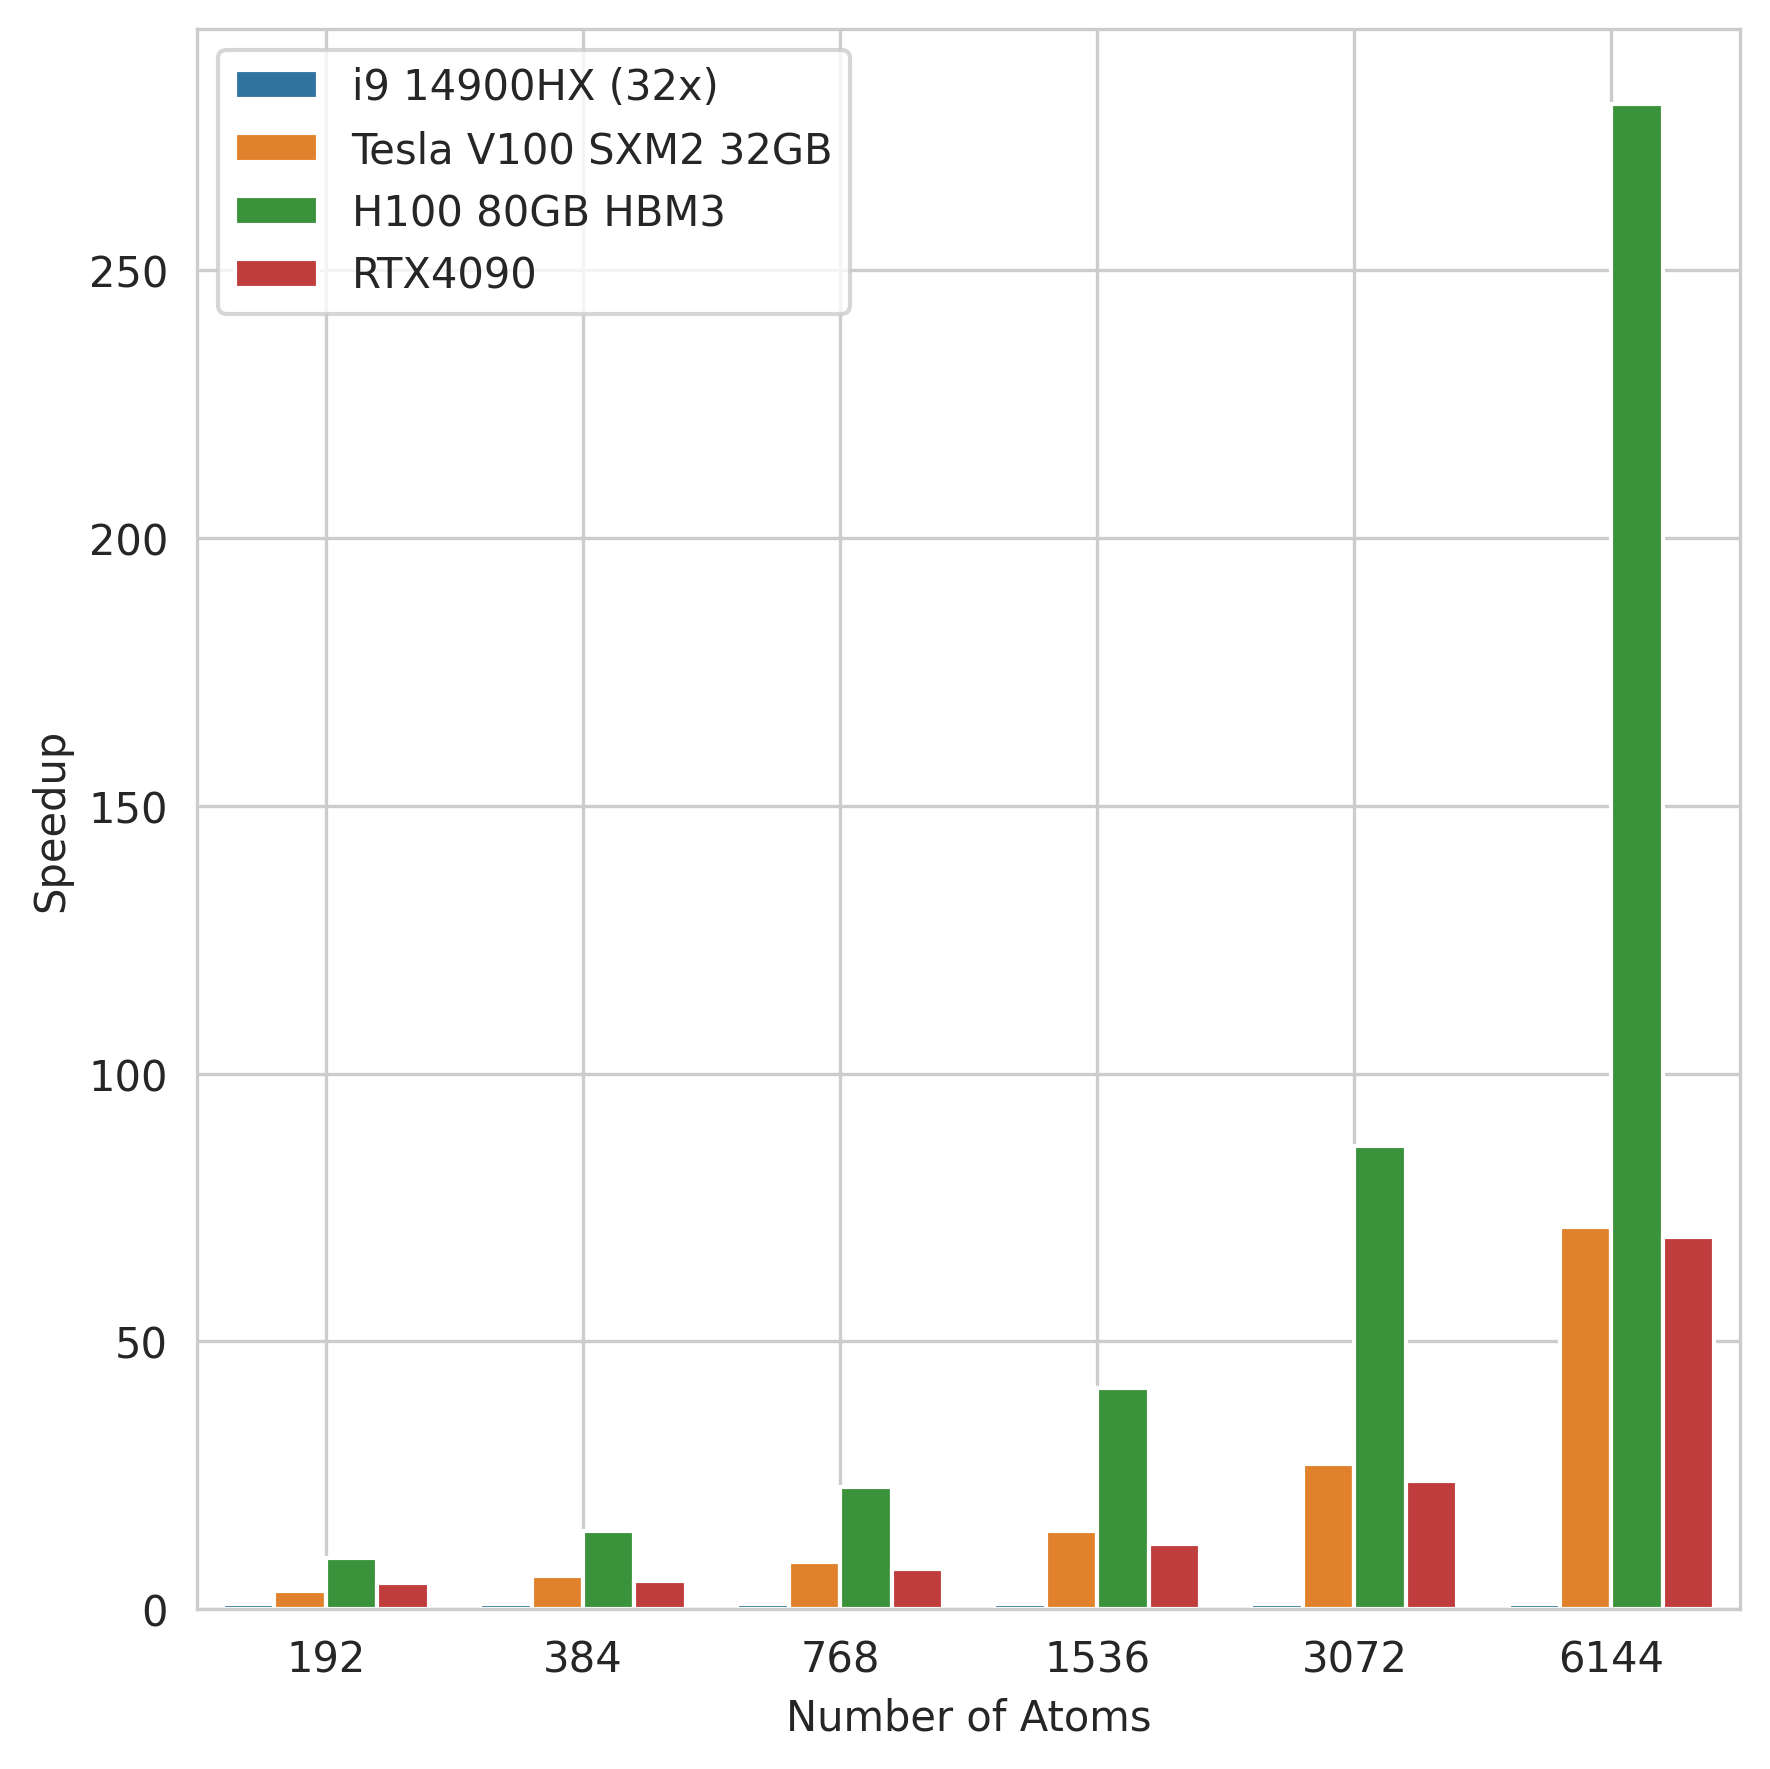

In [17]:
from IPython.display import display

def relative_perf_plot(df):
  mask = ~df['structure'].str.contains('alkan')
  df = df[mask]

  out = []
  for i,g in df.groupby('nat'):
    cpu_time = g[g['processor'] == 'i9 14900HX (32x)']['time'].item()
    g['relative'] = cpu_time / g['time']
    display(g)
    out.append(g)
  df = pd.concat(out)

  sns.barplot(
    x='nat',
    y='relative',
    hue='processor',
    data=df
  )
  plt.xlabel("Number of Atoms")
  plt.ylabel("Speedup")
  plt.legend()
  plt.grid(True)

def relative_perf_plot_alk(df):
  mask = df['structure'].str.contains('alkan')
  df = df[mask]

  out = []
  for i,g in df.groupby('nat'):
    # display(g)
    cpu_time = g[g['processor'] == 'i9 14900HX (32x)']['time'].item()
    g['relative'] = cpu_time / g['time']
    out.append(g)
  df = pd.concat(out)

  sns.barplot(
    x='nat',
    y='relative',
    hue='processor',
    data=df
  )
  plt.xlabel("Number of Atoms")
  plt.ylabel("Speedup")
  plt.legend()
  plt.grid(True)
  
# sns.set_style("whitegrid")
# relative_perf_plot_alk(df)
# plt.figure(figsize=(15, 7))

sns.set_style("whitegrid")
# plt.subplot(121)
plt.figure(figsize=(6,6),dpi=300)
sns.set_style("whitegrid")
relative_perf_plot(df)
plt.tight_layout()
plt.savefig(output_dir/'gpu_vs_cpu_scaling.png')

# plt.subplot(122)
plt.figure(figsize=(6,6),dpi=300)
sns.set_style("whitegrid")
relative_perf_plot_alk(df)
plt.tight_layout()
plt.savefig(output_dir/'alkane_gpu_speedup.png')

In [6]:
structnamemap = {
  'GLU': "Glutamine",
  "dna": "DNA fragment",
  "dna": "DNA fragment",
  "1lyz-lysozyme": "1LYZ Lysozyme",
  "103l-hydrolase": "103L Lysozyme",
  "alkane_64": "64 alkane",
  "alkane_128": "128 alkane",
  "alkane_256": "256 alkane",
  "alkane_512": "512 alkane",
  "alkane_1024": "1024 alkane",
  "alkane_2048": "2048 alkane",
}
dx = df.groupby(['structure', 'nat', 'processor'])['time'].min() / 1000 # to seconds
dx = dx.reset_index().pivot(index=['structure', 'nat'], columns='processor', values='time')
dx = dx[dx.columns[::-1]]
dx['H100 Speedup'] = (dx['i9 14900HX (32x)'] / dx['H100 80GB HBM3']).round(3)
dx = dx.sort_values('H100 Speedup')
dx = dx.drop(columns="H100 Speedup")
dx = dx.reset_index().rename_axis(None, axis=1)
dx['structure'] =  dx['structure'].replace(structnamemap)
dx.columns = dx.columns.map({
  'structure': "Structure",
  "nat": "Atoms",
  "i9 14900HX (32x)": "i9 14900HX",
  "Tesla V100 SXM2 32GB": "Tesla V100",
  "RTX4090":"RTX4090",
  "H100 80GB HBM3":"H100",
  # "H100 Speedup":"H100 Speedup"
})
dx_speed = dx.copy()
display(dx)
print(dx.sort_values('Atoms').to_latex(index=False, float_format='%.5f', label='table:speedup', caption="Molecules and different execution times on evaluated systems, time shown in seconds."))

dx = df.dropna()
dx = dx.groupby("structure")[['gpu_gb_total', 'gpu_transfer_time']].median()
dx['gpu_transfer_time'] = dx['gpu_transfer_time'] / 1000
dx = dx.reset_index().rename_axis(None, axis=1)
dx['structure'] = dx['structure'].replace(structnamemap)

dx = dx.sort_values('gpu_transfer_time')
dx.columns = dx.columns.map({
  "structure": "Structure",
  "gpu_gb_total": "System size (GB)",
  "gpu_transfer_time": "Transfer time (s)",
})

# dx['i9 14900HX'] = dx_speed.loc[dx.Structure]['i9 14900HX (32x)']
dx = pd.merge(dx, dx_speed, on='Structure')
dx['CPU processing time (s)'] = dx['i9 14900HX']

dx = dx[['Structure', 'System size (GB)', 'CPU processing time (s)', 'Transfer time (s)']]
dx
print(dx
      .to_latex(index=False, label="table:transfer", float_format='%.5f', caption="CPU-to-GPU transfer times and sizes of transferred systems (in GB) and the CPU processing time."))
# display(dx)

,Structure,Atoms,i9 14900HX,Tesla V100,RTX4090,H100
0,Glutamine,29,0.012927,0.007997,0.011924,0.005526
1,64 alkane,192,0.007540,0.002224,0.001563,0.000794
2,DNA fragment,387,0.057029,0.015348,0.011825,0.004377
3,128 alkane,384,0.012869,0.002094,0.002429,0.000878
4,1LYZ Lysozyme,1102,0.231494,0.037256,0.028091,0.010338
5,256 alkane,768,0.028582,0.003249,0.003800,0.001249
6,103L Lysozyme,1404,0.324562,0.045226,0.034476,0.012072
7,512 alkane,1536,0.083131,0.005690,0.006792,0.002012
8,1024 alkane,3072,0.285172,0.010519,0.011933,0.003299
9,2048 alkane,6144,1.457929,0.020415,0.020977,0.005189


\begin{table}
\caption{Molecules and different execution times on evaluated systems, time shown in seconds.}
\label{table:speedup}
\begin{tabular}{lrrrrr}
\toprule
Structure & Atoms & i9 14900HX & Tesla V100 & RTX4090 & H100 \\
\midrule
Glutamine & 29 & 0.01293 & 0.00800 & 0.01192 & 0.00553 \\
64 alkane & 192 & 0.00754 & 0.00222 & 0.00156 & 0.00079 \\
128 alkane & 384 & 0.01287 & 0.00209 & 0.00243 & 0.00088 \\
DNA fragment & 387 & 0.05703 & 0.01535 & 0.01182 & 0.00438 \\
256 alkane & 768 & 0.02858 & 0.00325 & 0.00380 & 0.00125 \\
1LYZ Lysozyme & 1102 & 0.23149 & 0.03726 & 0.02809 & 0.01034 \\
103L Lysozyme & 1404 & 0.32456 & 0.04523 & 0.03448 & 0.01207 \\
512 alkane & 1536 & 0.08313 & 0.00569 & 0.00679 & 0.00201 \\
1024 alkane & 3072 & 0.28517 & 0.01052 & 0.01193 & 0.00330 \\
2048 alkane & 6144 & 1.45793 & 0.02042 & 0.02098 & 0.00519 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}
\caption{CPU-to-GPU transfer times and sizes of transferred systems (in GB) and the CPU processing

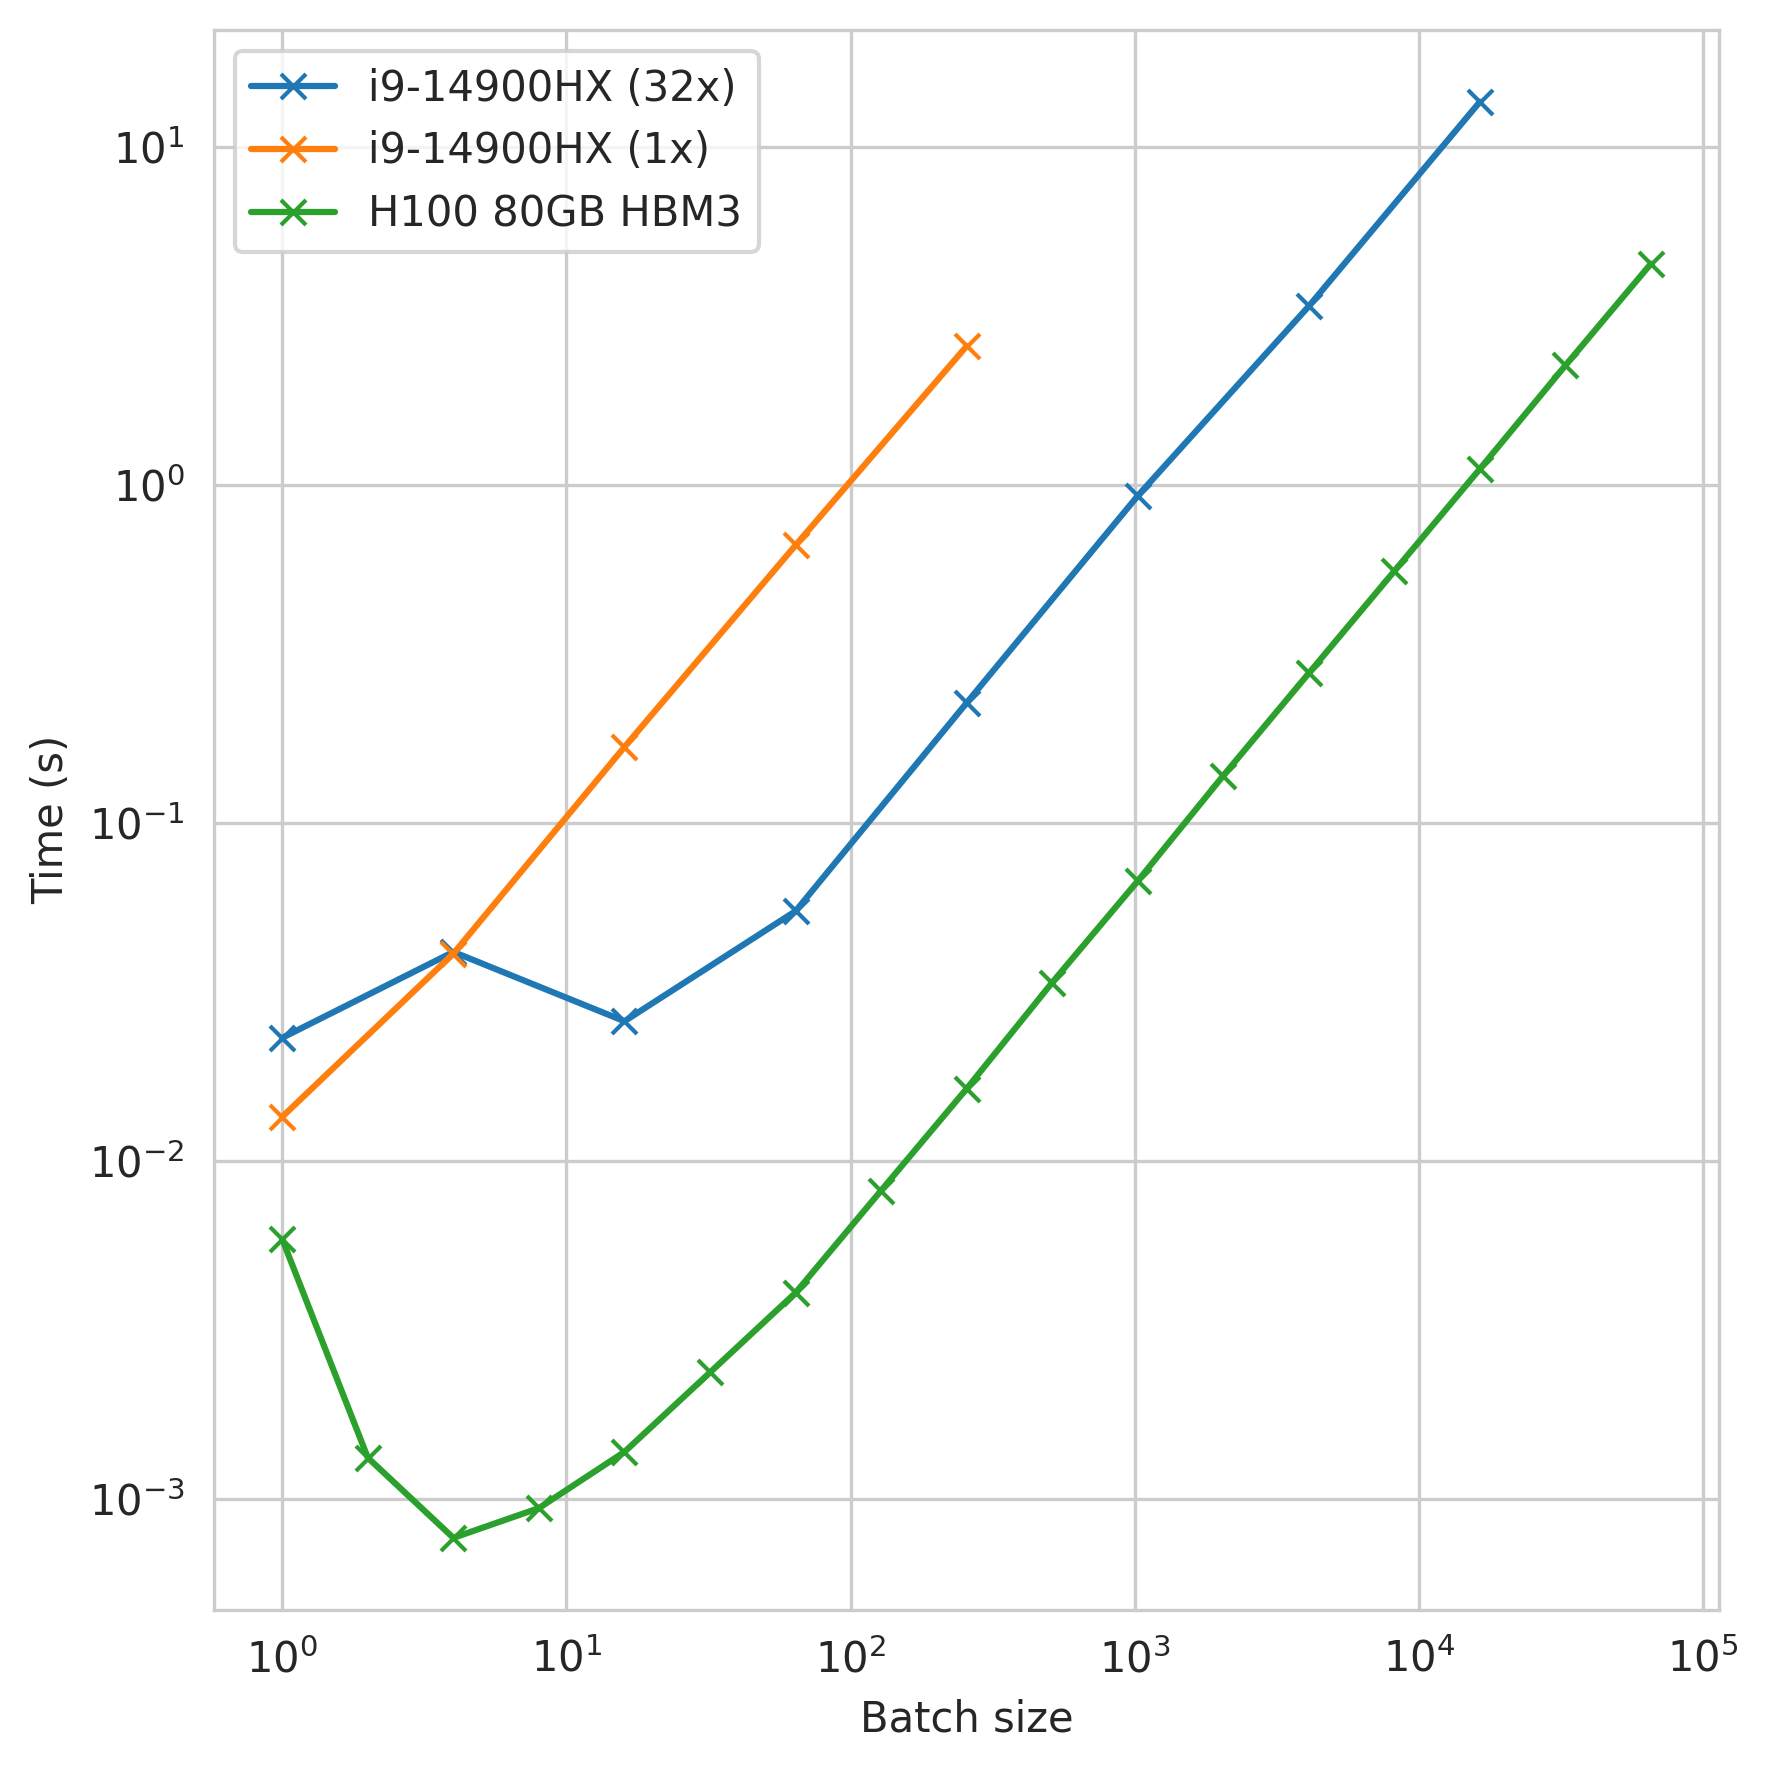

In [19]:
all_data = []
df = pd.read_csv('notes/data/i9-14900HX/32batchallcpu.csv')
df['processor'] = 'i9-14900HX (32x)'
df['time'] = df['cpu_time']
all_data.append(df)

df = pd.read_csv('notes/data/i9-14900HX/1batchcpu.csv')
df['processor'] = 'i9-14900HX (1x)'
df['time'] = df['cpu_time']
all_data.append(df)


df = pd.read_csv('notes/data/H100_80GB_HBM3/batchgpu.csv')
df['processor'] = 'H100 80GB HBM3'
df['time'] = df['gpu_time']
all_data.append(df)

df = pd.concat(all_data)
df

sns.set_style('whitegrid')
def relative_perf_plot(df):
  out = []
  # for i,g in df.groupby('nat')::
  #   # display(g)
  #   cpu_time = g[g['processor'] == 'i9 14900HX (32x)']['time'].item()
  #   g['relative'] = cpu_time / g['time']
  #   out.append(g)
  # df = pd.concat(out)
  for i,g in reversed(list(df.groupby('processor'))):
    plt.plot(
      g['batch_size'],
      g['time'] / 1000,
      # cpu_time / g['time'],
      'x-',
      label=str(i)
    )
  plt.xscale('log')
  plt.yscale('log')
  plt.xlabel("Batch size")
  plt.ylabel("Time (s)")
  plt.legend()
  plt.grid(True)



plt.figure(figsize=(6,6), dpi=300)
sns.set_style("whitegrid")
# plt.subplot(121)
relative_perf_plot(df)
plt.tight_layout()
plt.savefig(output_dir / 'batched_performance.png')
# plt.subplot(122)
# relative_perf_plot_alk(df)

In [20]:
df

,cpu_time,batch_size,processor,time,gpu_gb_in,gpu_gb_out,gpu_gb_total,gpu_between_atoms,gpu_in_atoms,gpu_time,gpu_transfer_time,gpu_walltime
0,23.146714,1,i9-14900HX (32x),23.146714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,41.541485,4,i9-14900HX (32x),41.541485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,25.911044,16,i9-14900HX (32x),25.911044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,54.858065,64,i9-14900HX (32x),54.858065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,226.617542,256,i9-14900HX (32x),226.617542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,928.558061,1024,i9-14900HX (32x),928.558061,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,3380.195741,4096,i9-14900HX (32x),3380.195741,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,13606.760627,16384,i9-14900HX (32x),13606.760627,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,13.515938,1,i9-14900HX (1x),13.515938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,41.075046,4,i9-14900HX (1x),41.075046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
!meson compile -C build/ && ./build/app/tblite test/perf/aspirin.sdf

INFO: autodetecting backend as ninja
INFO: calculating backend command to run: /usr/bin/ninja -C /home/tornikeo/Documents/personal/thesis/qcxms/subprojects/tblite/build
ninja: Entering directory `/home/tornikeo/Documents/personal/thesis/qcxms/subprojects/tblite/build'
ninja: no work to do.
xTB calculator
 | screened Coulomb repulsion
 | Coulomb electrostatics
 |  * isotropic Klopman-Ohno electrostatics
 |  * anisotropic electrostatics
 |  * onsite third-order electrostatics
 | self-consistent DFT-D4 dispersion

 repulsion energy        4.5921005160310E-01 Eh
 dispersion energy       9.2864624768801E-05 Eh
 number of electrons     6.8000000000000E+01 e
 integral cutoff         1.7347787504999E+01 bohr

 nat          21
 nprim           4
 maxl           1
 max_nnl          20
 mean_nnl          10
 max_nsh           2
------------------------------------------------------------
  cycle        total energy    energy error   density error
--------------------------------------------------

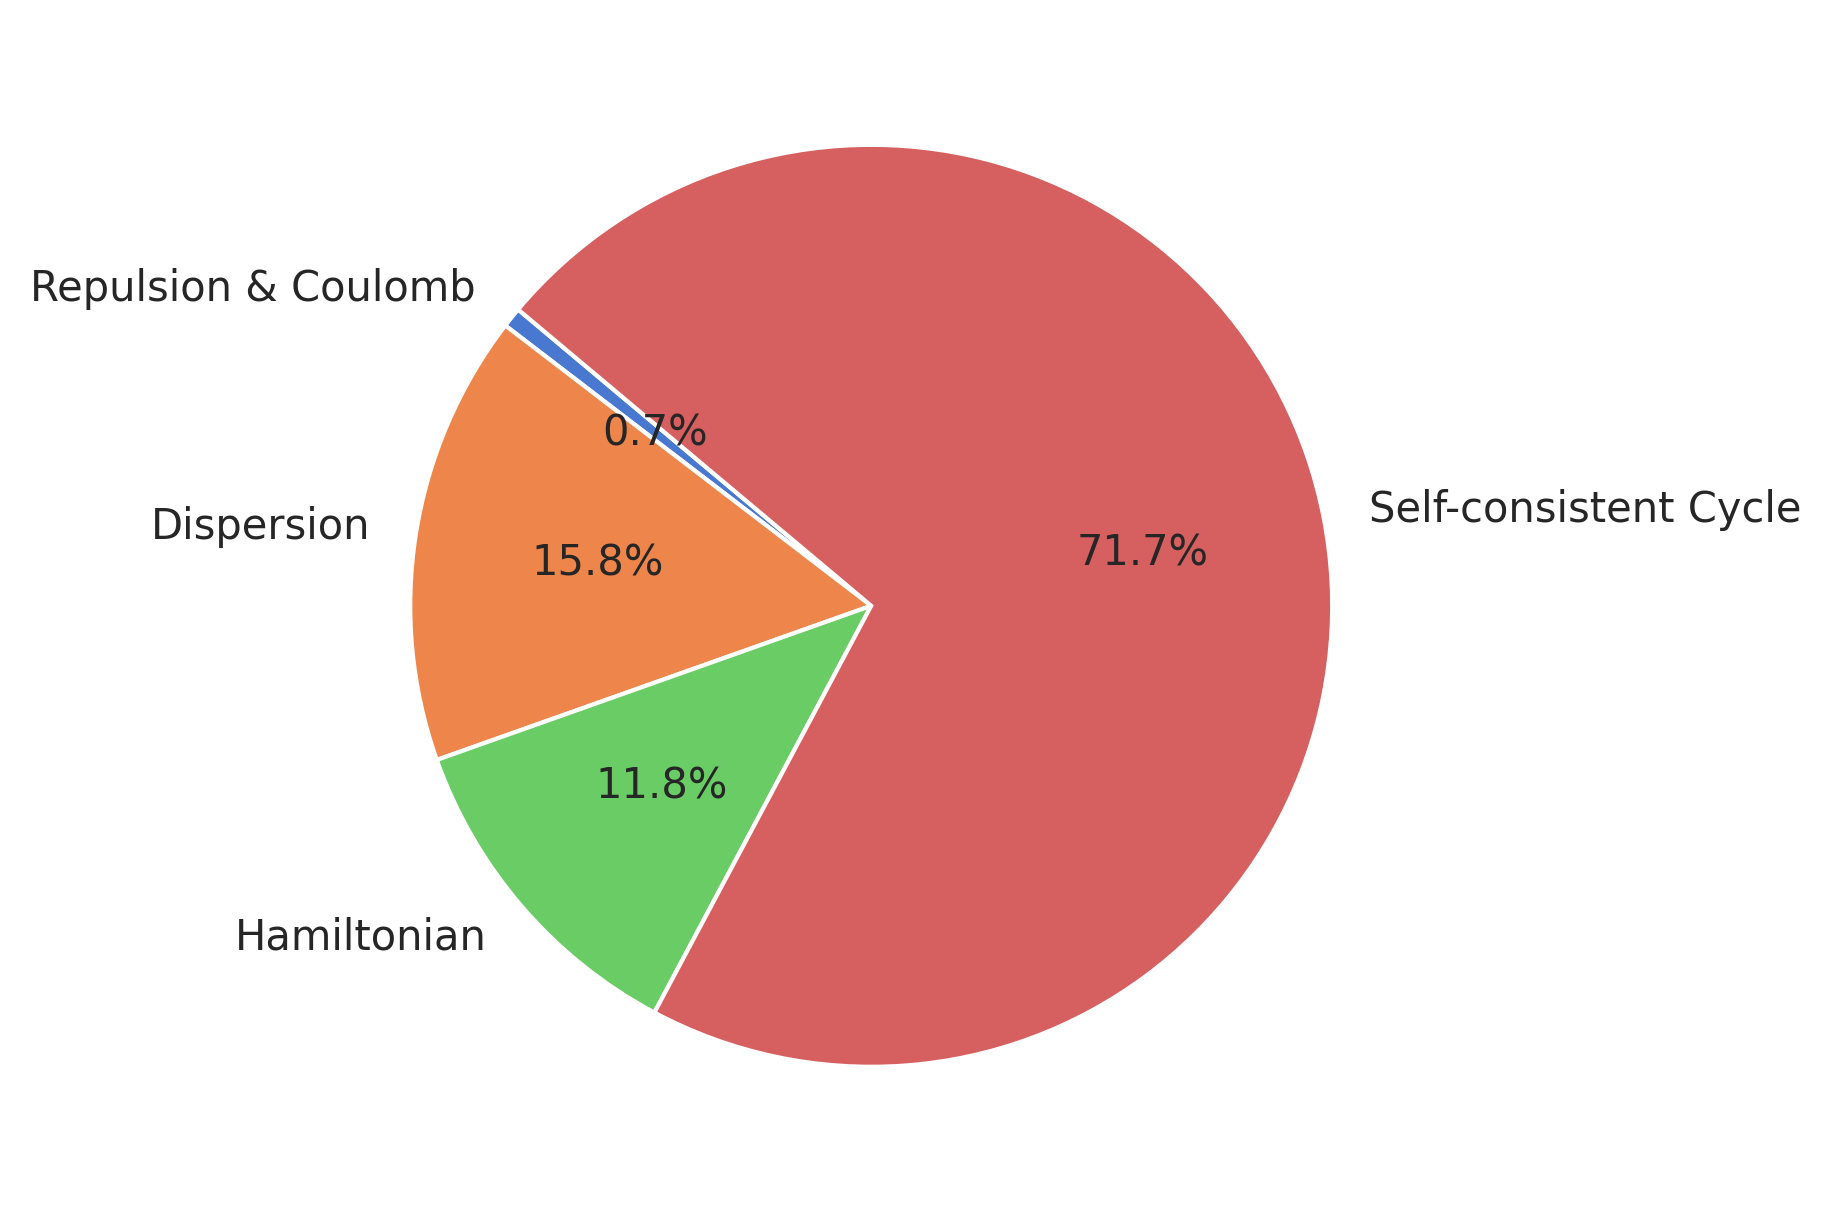

In [22]:
#  - repulsion                               0.00004974 sec (                                  0%)
#  - coulomb                                 0.00024547 sec (                                  0%)
#  - hamiltonian                             0.00490927 sec (                                 11%)
#  - scc                                     0.02987670 sec (                                 71%)

times = {
  "Repulsion & Coulomb": 0.00004974 + 0.00024547,
  "Dispersion": 0.00659769, # Small molecules don't benefit much from this
  # "coulomb": 0.00024547,
  "Hamiltonian": 0.00490927,
  "Self-consistent Cycle": 0.02987670,
}

# Pie chart on time spent in each part of the calculation, with annotations

sns.set_style("whitegrid")
plt.figure(figsize=(6,6), dpi=300)
# set font, arial and large
# plt.rcParams['font.size'] = 20
plt.pie(times.values(), labels=times.keys(), autopct='%1.1f%%', startangle=140, 
        colors=sns.color_palette("muted", n_colors=len(times)))
# plt.title('Time spent in each part of the calculation (Aspirin)')
# plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# plt.show()
plt.tight_layout()
# Save the figure
# plt.savefig('notes/figures/performance_pie.png', dpi=300, bbox_inches='tight')
plt.savefig(output_dir / 'singlepoint_piechart.png')